In [1]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
import astrodendro
import os
from astropy import wcs
from astrodendro import Dendrogram, pp_catalog
from astrodendro.analysis import PPStatistic
from astropy.table import Table, hstack, Column
from astropy.utils.console import ProgressBar
import reproject
import pyregion


In [2]:
# Image information and assumptions
distance        = 8340. # distance to GC; Reid et al. 2014
#Temp            = 20.0
Wave            = (3.0e8/226.e9)
Wave0           = 1.3e-3
k0              = 0.899
nu              = 3.e08/Wave
nu0             = 3.e08/Wave0
beta            = 1.75
Kappag2d        = k0*((nu/nu0)**beta)
g2d             = 100.0
Kappa           = Kappag2d / g2d
mu              = 2.8 # express everything in H2

dustTemp = 20

# Constants
G = 6.67408e-11
msun = 1.989e33
mh = 1.6737236e-27
pc2cm = 3.08567758e18
as2persr = 4.25e10 
percm2perm = 1.0e6
JyperSr_to_JyperPix = (3.0462*(10**-4))*((0.00013888888888)**2)
JyperSr_to_Jyperassqr = ((np.pi*180.)**(-2))*(3600**(-1))
hplanck = 6.63e-34
clight = 2.99792e8
kboltzmann = 1.381e-23
sin1yr = 3.15569e7
arcsec2pc = distance/((360./(2.*np.pi))*60.*60.)

### Define physical property functions

def planck_wave( Wave, Temp ):

    # Planck function using wavelength

    planck_conv_wave = 1.e-26 * clight / Wave**2.0

    planck = ((2.0*hplanck*clight**2.0)/(Wave**5.0))*(1.0/(np.exp((hplanck*clight)/(Wave*kboltzmann*Temp))-1.0))
    planck = planck/planck_conv_wave

    return planck

def mass_calc_submm( Wave, Temp, Kappa, Integrated_Flux, Obj_Dist ):

    Obj_Dist = Obj_Dist * pc2cm
    #from planck_func import planck_wave
    B = planck_wave( Wave, Temp )
    Mass = (Obj_Dist**2. * Integrated_Flux) / ( Kappa * B )
    Mass = Mass / msun
    return Mass

def column_density(Wave, Temp, Kappa, Flux, mu):

    #from planck_func import planck_wave

    B = planck_wave( Wave, Temp )

    N = Flux / (mu * (mh*1.e3) * Kappa * B)

    return N

def number_density_sphere_pc( Mass_sol, Radius_pc, mu ):

    # This subroutine accepts mass in solar masses and radius in pc and calculates the number density.

    Mass = Mass_sol * (msun/1000.0)
    Radius = Radius_pc * (pc2cm/100.0)

    n = Mass / (((4. / 3.)*np.pi) * mu * mh * Radius**3.0)

    # Convert to particles per cubic centimetre

    n = n / percm2perm

    return n

def mass_density_sphere( Mass_sol, Radius_pc ):

    # This subroutine accepts mass in solar masses and radius in pc and calculates the mass density.

    Mass = Mass_sol * (msun/1000.0)
    Radius = Radius_pc * (pc2cm/100.0)

    rho = Mass / (((4. / 3.)*np.pi) * Radius**3.0)

    return rho

def tff_spherical( number_density, mu ):

    # Accepts a number density in units of particles per cubic centimetre and derives the free fall time in yrs

    mass_density = mu * mh * number_density * percm2perm

    tff = np.sqrt( (3. * np.pi) / (32. * G * mass_density) )

    tff = tff / sin1yr # free-fall time in years

    return tff

def radius_from_mass_const_col_density(Mass_solar,col_dens):
    #print Mass_solar
    Mass = Mass_solar * (msun/1000.0)
    #print Mass
    col_dens = col_dens * (10**4) #convert from cm^-2 to m^-2

    Radius_sqrd = (Mass / (mu * mh * col_dens)) / (np.pi)
    #print Radius_cubed
    Radius_cm = Radius_sqrd**(1./2.)
    #print Radius_cm
    Radius_pc = Radius_cm / (pc2cm/100)
    return Radius_pc
   
    
def mass_from_radius_const_col_density(Radius_pc,col_dens):
    Radius_cm = Radius_pc * (pc2cm)#/100) 
    Radius_sqrd = Radius_cm**2
    Mass = Radius_sqrd * (np.pi) * (mu * mh * col_dens)
    col_dens = col_dens * (10**4) #convert from cm^-2 to m^-2
    Mass_solar = Mass / (msun/1000.0)
    return Mass_solar

In order to characterize the variation in the effective radius of each structure we performed a simple parameter study, modulating the initial dendrogram's minimum $\delta$ parameter. As described in section $N$, this parameter characterizes the minimum required difference in intensity between an independent structure and the local minima that separated that structure from any adjacent independent structure in the dendrogram. A separate dendrogram was constructed for three $\delta$ values: $\delta = 1$, our fidelity value (the one used the CMZoom catalog) of $\delta = 2$, and $\delta = 3$. Those dendrograms are then processed with the same pruning as the catalog to produce a low-$\delta$ catalog, our fidelity catalog, and a high-$\delta$ catalog. The effect that this variation has on the catalog results is described in figures $N$ and $N+1$.

Two cases arise in our catalog for variations in $\delta$: leaves can change shape, and therefore also integrated flux, or two nearby leaves can merge together or divide. The former case is more common than the latter, but both cases are fairly rare and only occur for lower flux sources. The effect that changes in $\delta$ have on the catalog as a whole are represented in figure $N+3$. 

In [5]:
### define cataloging function
def run_characterization(Target, DStructure, final_noisemap,pp,pm,filesuffix,path):
    InputMap = fits.open(Target)[0]
    HeaderMod = InputMap.header.copy()
    PixelAreaArcsec = 3600. * abs(InputMap.header['CDELT1']) * 3600. * abs(InputMap.header['CDELT2'])
    ### Compile Metadata
    Metadata = {}
    Metadata['data_unit'] = u.Jy / u.sr
    Metadata['spatial_scale'] =  PixelAreaArcsec**0.5 * u.arcsec
    Metadata['wcs'] = wcs.WCS(header=HeaderMod).celestial
    ### Actually build the catalog from the initial dendrogram
    Catalogue = astrodendro.pp_catalog(DStructure, Metadata)
    ### Customize catalog with units and coordinate system
    Catalogue['x_cen'].unit = u.deg
    Catalogue['y_cen'].unit = u.deg
    Catalogue.rename_column('_idx', 'index')
    Catalogue.rename_column('flux', 'flux_integrated')
    Catalogue.rename_column('x_cen', 'glon')
    Catalogue.rename_column('y_cen', 'glat')
    Catalogue['flux_integrated'].unit = u.Jy
    Catalogue['flux_integrated'] = Catalogue['flux_integrated']
    Catalogue['r_eff'] = (Catalogue['area_exact']/np.pi)**0.5
    Catalogue['r_eff'].unit = u.arcsec
    Catalogue['glon'].unit = u.deg
    Catalogue['glat'].unit = u.deg
    
    ### Add a 'noise' column to the catalog
    keys = ['testflux_integrated', 'flux_integrated_bgsub','min_flux_integrated', 'noise', 'is_leaf', 'peak_cont_flux', 'min_cont_flux', 'mean_cont_flux','npix']
    columns = {k:[] for k in (keys)}
    
    for ii, row in enumerate(ProgressBar(Catalogue)):
        structure = DStructure[row['index']]
        assert structure.idx == row['index'] == ii
        dend_inds = structure.indices()
        columns['noise'].append(final_noisemap[dend_inds].mean())
        columns['is_leaf'].append(structure.is_leaf)
        peakflux = data[dend_inds].max()
        testflux = np.nansum(data[dend_inds])
        testflux_integrated = testflux*JyperSr_to_JyperPix
        minflux = data[dend_inds].min()
        numpix = np.shape(dend_inds)[1]
        backgroundflux = minflux*numpix*JyperSr_to_JyperPix
        columns['flux_integrated_bgsub'].append(Catalogue['flux_integrated'][ii] - backgroundflux)
        columns['peak_cont_flux'].append(peakflux)
        columns['min_cont_flux'].append(data[dend_inds].min())
        columns['mean_cont_flux'].append(data[dend_inds].mean())
        columns['npix'].append(numpix)
        columns['min_flux_integrated'].append(backgroundflux)
        columns['testflux_integrated'].append(testflux_integrated)
        
    for k in columns:
        if k not in Catalogue.keys():
            Catalogue.add_column(Column(name=k, data=columns[k]))
    
    Catalogue['peak_cont_flux'].unit = u.Jy / u.sr
    Catalogue['mean_cont_flux'].unit = u.Jy / u.sr
    Catalogue['mean_cont_flux'].unit = u.Jy / u.sr
    
    #pruning
    print( "Pruning...")
    cat_mask = (Catalogue['is_leaf'] &
                (Catalogue['peak_cont_flux']>pp*Catalogue['noise']) &
                (Catalogue['mean_cont_flux']>pm*Catalogue['noise']))
    pruned_ppcat = Catalogue[cat_mask]
    mask = DStructure.index_map.copy()
    for ii in ProgressBar(list(range(len(Catalogue)))):
        if ii not in pruned_ppcat['index']:
            mask[mask == ii] = -1
    outf = fits.PrimaryHDU(data=mask, header=HeaderMod)
    print( "Writing mask file...")
    outf.writeto(path + 'dendrogram_mask_pruned'+filesuffix+'.fits', clobber=True)
    
    print("Writing region file...")
    with open(path+"raw_dendrogram_cores"+filesuffix+".reg", 'w') as fh:
        fh.write("galactic\n")
        for row in pruned_ppcat:
            fh.write("ellipse({glon}, {glat}, {major_sigma}\", "
                     "{minor_sigma}\", {position_angle}) # text={{{index}}}\n"
                     .format(**dict(zip(row.colnames, row))))
    
    print("Writing data table...")        
    OutputPath = path + 'catalog'+'_datatab'+filesuffix+'.fits'
    if os.path.isfile(OutputPath):
        os.remove(OutputPath)
    pruned_ppcat.write(OutputPath,
                    format='fits')
    print("Data table written!")

In [6]:
### run two (additional) catalogs, save to a new folder
### use delta = 1, delta = 2, delta = 3
#ASSIGN PARAMETERS

rms = 3.*10**6
dend_min_v = 3
dend_min_d1 = 1
dend_min_d2 = 2
dend_min_d3 = 3
dend_min_pix = 17
prune_min_peak = 6
prune_min_mean = 2


date = '_2-11-20'
directory = '/Users/hph/cmzoom_catalog/catalog_parameter_study/'
target = directory+'CMZoom_continuum_pbcor.fits'
filesuffix1 = '_rms3e6_dv'+str(dend_min_v)+'_dd'+str(dend_min_d1)+'_dp'+str(dend_min_pix)+'_pp'+str(prune_min_peak)+'_pm'+str(prune_min_mean)+'_gal'+date
filesuffix2 = '_rms3e6_dv'+str(dend_min_v)+'_dd'+str(dend_min_d2)+'_dp'+str(dend_min_pix)+'_pp'+str(prune_min_peak)+'_pm'+str(prune_min_mean)+'_gal'+date
filesuffix3 = '_rms3e6_dv'+str(dend_min_v)+'_dd'+str(dend_min_d3)+'_dp'+str(dend_min_pix)+'_pp'+str(prune_min_peak)+'_pm'+str(prune_min_mean)+'_gal'+date


sma = fits.open(target)
data = sma[0].data
HeaderMod = sma[0].header

mywcs = wcs.WCS(HeaderMod)

print( "Running dendrogram...")
dend1 = astrodendro.Dendrogram.compute(data, min_value=float(dend_min_v)*rms, min_delta=float(dend_min_d1)*rms,
                                      min_npix=dend_min_pix,
                                      wcs=mywcs)
print( "Dendrogram 1 complete!")
#Save the dendrogram to the working directory (temporary)
dend1.save_to(directory+'/prototype_dendrogram'+filesuffix1+'.fits')

dend2 = astrodendro.Dendrogram.compute(data, min_value=float(dend_min_v)*rms, min_delta=float(dend_min_d2)*rms,
                                      min_npix=dend_min_pix,
                                      wcs=mywcs)
print( "Dendrogram 2 complete!")
#Save the dendrogram to the working directory (temporary)
dend2.save_to(directory+'/prototype_dendrogram'+filesuffix2+'.fits')

dend3 = astrodendro.Dendrogram.compute(data, min_value=float(dend_min_v)*rms, min_delta=float(dend_min_d3)*rms,
                                      min_npix=dend_min_pix,
                                      wcs=mywcs)
print( "Dendrogram 3 complete!")
#Save the dendrogram to the working directory (temporary)
dend3.save_to(directory+'/prototype_dendrogram'+filesuffix3+'.fits')

noisemap = fits.open(directory+'CMZoom_noisemap_JySr_k14_final.fits')
noisemap_data = noisemap[0].data
print( "Running characterization...")
#Perform pruning and save catalog to working directory (temporary)
run_characterization(target,dend1,noisemap_data,float(prune_min_peak),float(prune_min_mean),filesuffix1,directory)
run_characterization(target,dend2,noisemap_data,float(prune_min_peak),float(prune_min_mean),filesuffix2,directory)
run_characterization(target,dend3,noisemap_data,float(prune_min_peak),float(prune_min_mean),filesuffix3,directory)
print( "Characterization complete!")


Running dendrogram...
Dendrogram 1 complete!
Dendrogram 2 complete!
Dendrogram 3 complete!
Running characterization...
Computing catalog for 24749 structures

[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        


[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>          

[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>           

[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>           

[>                                        ] 2%
[>                                        ] 2%
[>                                        ] 2%
[>                                        ] 2%
[>                                        ] 2%
[>                                        ] 2%
[>                                        ] 2%
[>                                        ] 2%
[>                                        ] 2%
[>                                        ] 2%
[>                                        ] 2%
[>                                        ] 2%
[>                                        ] 2%
[>                                        ] 2%
[>                                        ] 2%
[>                                        ] 2%
[>                                        ] 2%
[>                                        ] 2%
[>                                        ] 2%
[>                                        ] 2%
[>                                        ] 2%
[>           

[=>                                       ] 2%
[=>                                       ] 2%
[=>                                       ] 2%
[=>                                       ] 2%
[=>                                       ] 2%
[=>                                       ] 2%
[=>                                       ] 2%
[=>                                       ] 2%
[=>                                       ] 2%
[=>                                       ] 2%
[=>                                       ] 2%
[=>                                       ] 2%
[=>                                       ] 2%
[=>                                       ] 2%
[=>                                       ] 2%
[=>                                       ] 2%
[=>                                       ] 2%
[=>                                       ] 2%
[=>                                       ] 2%
[=>                                       ] 3%
[=>                                       ] 3%
[=>          

[=>                                       ] 3%
[=>                                       ] 3%
[=>                                       ] 3%
[=>                                       ] 3%
[=>                                       ] 3%
[=>                                       ] 3%
[=>                                       ] 3%
[=>                                       ] 3%
[=>                                       ] 3%
[=>                                       ] 3%
[=>                                       ] 3%
[=>                                       ] 3%
[=>                                       ] 3%
[=>                                       ] 3%
[=>                                       ] 3%
[=>                                       ] 3%
[=>                                       ] 3%
[=>                                       ] 3%
[=>                                       ] 3%
[=>                                       ] 3%
[=>                                       ] 3%
[=>          

[=>                                       ] 4%
[=>                                       ] 4%
[=>                                       ] 4%
[=>                                       ] 4%
[=>                                       ] 4%
[=>                                       ] 4%
[=>                                       ] 4%
[=>                                       ] 4%
[=>                                       ] 4%
[=>                                       ] 4%
[=>                                       ] 4%
[=>                                       ] 4%
[=>                                       ] 4%
[=>                                       ] 4%
[=>                                       ] 4%
[=>                                       ] 4%
[=>                                       ] 4%
[=>                                       ] 4%
[=>                                       ] 4%
[=>                                       ] 4%
[=>                                       ] 4%
[=>          

[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>         

[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>         

[==>                                      ] 6%
[==>                                      ] 6%
[==>                                      ] 6%
[==>                                      ] 6%
[==>                                      ] 6%
[==>                                      ] 6%
[==>                                      ] 6%
[==>                                      ] 6%
[==>                                      ] 6%
[==>                                      ] 6%
[==>                                      ] 6%
[==>                                      ] 6%
[==>                                      ] 6%
[==>                                      ] 6%
[==>                                      ] 6%
[==>                                      ] 6%
[==>                                      ] 6%
[==>                                      ] 6%
[==>                                      ] 6%
[==>                                      ] 6%
[==>                                      ] 6%
[==>         

[==>                                      ] 7%
[==>                                      ] 7%
[==>                                      ] 7%
[==>                                      ] 7%
[==>                                      ] 7%
[==>                                      ] 7%
[==>                                      ] 7%
[==>                                      ] 7%
[==>                                      ] 7%
[==>                                      ] 7%
[==>                                      ] 7%
[==>                                      ] 7%
[==>                                      ] 7%
[==>                                      ] 7%
[==>                                      ] 7%
[==>                                      ] 7%
[==>                                      ] 7%
[==>                                      ] 7%
[==>                                      ] 7%
[==>                                      ] 7%
[==>                                      ] 7%
[==>         

[===>                                     ] 7%
[===>                                     ] 7%
[===>                                     ] 7%
[===>                                     ] 7%
[===>                                     ] 7%
[===>                                     ] 7%
[===>                                     ] 7%
[===>                                     ] 7%
[===>                                     ] 7%
[===>                                     ] 7%
[===>                                     ] 7%
[===>                                     ] 7%
[===>                                     ] 7%
[===>                                     ] 7%
[===>                                     ] 7%
[===>                                     ] 7%
[===>                                     ] 7%
[===>                                     ] 7%
[===>                                     ] 7%
[===>                                     ] 7%
[===>                                     ] 7%
[===>        

[===>                                     ] 8%
[===>                                     ] 8%
[===>                                     ] 8%
[===>                                     ] 8%
[===>                                     ] 8%
[===>                                     ] 8%
[===>                                     ] 8%
[===>                                     ] 8%
[===>                                     ] 8%
[===>                                     ] 8%
[===>                                     ] 8%
[===>                                     ] 8%
[===>                                     ] 8%
[===>                                     ] 8%
[===>                                     ] 8%
[===>                                     ] 8%
[===>                                     ] 8%
[===>                                     ] 8%
[===>                                     ] 8%
[===>                                     ] 8%
[===>                                     ] 8%
[===>        

[===>                                     ] 9%
[===>                                     ] 9%
[===>                                     ] 9%
[===>                                     ] 9%
[===>                                     ] 9%
[===>                                     ] 9%
[===>                                     ] 9%
[===>                                     ] 9%
[===>                                     ] 9%
[===>                                     ] 9%
[===>                                     ] 9%
[===>                                     ] 9%
[===>                                     ] 9%
[===>                                     ] 9%
[===>                                     ] 9%
[===>                                     ] 9%
[===>                                     ] 9%
[===>                                     ] 9%
[===>                                     ] 9%
[===>                                     ] 9%
[===>                                     ] 9%
[===>        

[===>                                     ] 9%
[===>                                     ] 9%
[===>                                     ] 9%
[===>                                     ] 9%
[===>                                     ] 9%
[===>                                     ] 9%
[===>                                     ] 9%
[===>                                     ] 9%
[===>                                     ] 9%
[===>                                     ] 9%
[===>                                     ] 9%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[==

[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                  

[====>                                    ] 11%
[====>                                    ] 11%
[====>                                    ] 11%
[====>                                    ] 11%
[====>                                    ] 11%
[====>                                    ] 11%
[====>                                    ] 11%
[====>                                    ] 11%
[====>                                    ] 11%
[====>                                    ] 11%
[====>                                    ] 11%
[====>                                    ] 11%
[====>                                    ] 11%
[====>                                    ] 11%
[====>                                    ] 11%
[====>                                    ] 11%
[====>                                    ] 11%
[====>                                    ] 11%
[====>                                    ] 11%
[====>                                    ] 11%
[====>                                  

[====>                                    ] 12%
[====>                                    ] 12%
[====>                                    ] 12%
[====>                                    ] 12%
[====>                                    ] 12%
[====>                                    ] 12%
[====>                                    ] 12%
[====>                                    ] 12%
[====>                                    ] 12%
[====>                                    ] 12%
[====>                                    ] 12%
[====>                                    ] 12%
[====>                                    ] 12%
[====>                                    ] 12%
[====>                                    ] 12%
[====>                                    ] 12%
[====>                                    ] 12%
[====>                                    ] 12%
[====>                                    ] 12%
[====>                                    ] 12%
[====>                                  

[=====>                                   ] 12%
[=====>                                   ] 12%
[=====>                                   ] 12%
[=====>                                   ] 12%
[=====>                                   ] 12%
[=====>                                   ] 12%
[=====>                                   ] 12%
[=====>                                   ] 12%
[=====>                                   ] 12%
[=====>                                   ] 12%
[=====>                                   ] 12%
[=====>                                   ] 12%
[=====>                                   ] 12%
[=====>                                   ] 12%
[=====>                                   ] 12%
[=====>                                   ] 12%
[=====>                                   ] 12%
[=====>                                   ] 12%
[=====>                                   ] 12%
[=====>                                   ] 12%
[=====>                                 

[=====>                                   ] 13%
[=====>                                   ] 13%
[=====>                                   ] 13%
[=====>                                   ] 13%
[=====>                                   ] 13%
[=====>                                   ] 13%
[=====>                                   ] 13%
[=====>                                   ] 13%
[=====>                                   ] 13%
[=====>                                   ] 13%
[=====>                                   ] 13%
[=====>                                   ] 13%
[=====>                                   ] 13%
[=====>                                   ] 13%
[=====>                                   ] 13%
[=====>                                   ] 13%
[=====>                                   ] 13%
[=====>                                   ] 13%
[=====>                                   ] 13%
[=====>                                   ] 13%
[=====>                                 

[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                 

[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                 

[======>                                  ] 15%
[======>                                  ] 15%
[======>                                  ] 15%
[======>                                  ] 15%
[======>                                  ] 15%
[======>                                  ] 15%
[======>                                  ] 15%
[======>                                  ] 15%
[======>                                  ] 15%
[======>                                  ] 15%
[======>                                  ] 15%
[======>                                  ] 15%
[======>                                  ] 15%
[======>                                  ] 15%
[======>                                  ] 15%
[======>                                  ] 15%
[======>                                  ] 15%
[======>                                  ] 15%
[======>                                  ] 15%
[======>                                  ] 15%
[======>                                

[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                

[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                

[=======>                                 ] 17%
[=======>                                 ] 17%
[=======>                                 ] 17%
[=======>                                 ] 17%
[=======>                                 ] 17%
[=======>                                 ] 17%
[=======>                                 ] 17%
[=======>                                 ] 17%
[=======>                                 ] 17%
[=======>                                 ] 17%
[=======>                                 ] 17%
[=======>                                 ] 17%
[=======>                                 ] 17%
[=======>                                 ] 17%
[=======>                                 ] 17%
[=======>                                 ] 17%
[=======>                                 ] 17%
[=======>                                 ] 17%
[=======>                                 ] 17%
[=======>                                 ] 17%
[=======>                               

[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                               

[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                               

[=======>                                 ] 19%
[=======>                                 ] 19%
[=======>                                 ] 19%
[=======>                                 ] 19%
[=======>                                 ] 19%
[=======>                                 ] 19%
[=======>                                 ] 19%
[=======>                                 ] 19%
[=======>                                 ] 19%
[=======>                                 ] 19%
[=======>                                 ] 19%
[=======>                                 ] 19%
[=======>                                 ] 19%
[=======>                                 ] 19%
[=======>                                 ] 19%
[=======>                                 ] 19%
[=======>                                 ] 19%
[=======>                                 ] 19%
[=======>                                 ] 19%
[=======>                                 ] 19%
[=======>                               

[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                              

[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 21%
[========>                                ] 21%
[========>                                ] 21%
[========>                                ] 21%
[========>                                ] 21%
[========>                                ] 21%
[========>                              

[========>                                ] 21%
[========>                                ] 21%
[========>                                ] 21%
[========>                                ] 21%
[========>                                ] 21%
[========>                                ] 21%
[========>                                ] 21%
[========>                                ] 21%
[========>                                ] 21%
[========>                                ] 21%
[========>                                ] 21%
[========>                                ] 21%
[========>                                ] 21%
[========>                                ] 21%
[========>                                ] 21%
[========>                                ] 21%
[========>                                ] 21%
[========>                                ] 21%
[========>                                ] 21%
[========>                                ] 21%
[========>                              

[========>                                ] 22%
[========>                                ] 22%
[========>                                ] 22%
[========>                                ] 22%
[========>                                ] 22%
[========>                                ] 22%
[========>                                ] 22%
[========>                                ] 22%
[========>                                ] 22%
[========>                                ] 22%
[========>                                ] 22%
[========>                                ] 22%
[========>                                ] 22%
[========>                                ] 22%
[========>                                ] 22%
[========>                                ] 22%
[========>                                ] 22%
[========>                                ] 22%
[========>                                ] 22%
[========>                                ] 22%
[========>                              

[=========>                               ] 23%
[=========>                               ] 23%
[=========>                               ] 23%
[=========>                               ] 23%
[=========>                               ] 23%
[=========>                               ] 23%
[=========>                               ] 23%
[=========>                               ] 23%
[=========>                               ] 23%
[=========>                               ] 23%
[=========>                               ] 23%
[=========>                               ] 23%
[=========>                               ] 23%
[=========>                               ] 23%
[=========>                               ] 23%
[=========>                               ] 23%
[=========>                               ] 23%
[=========>                               ] 23%
[=========>                               ] 23%
[=========>                               ] 23%
[=========>                             

[=========>                               ] 23%
[=========>                               ] 23%
[=========>                               ] 23%
[=========>                               ] 23%
[=========>                               ] 23%
[=========>                               ] 23%
[=========>                               ] 23%
[=========>                               ] 23%
[=========>                               ] 23%
[=========>                               ] 23%
[=========>                               ] 23%
[=========>                               ] 23%
[=========>                               ] 23%
[=========>                               ] 23%
[=========>                               ] 23%
[=========>                               ] 23%
[=========>                               ] 23%
[=========>                               ] 23%
[=========>                               ] 23%
[=========>                               ] 23%
[=========>                             

[=========>                               ] 24%
[=========>                               ] 24%
[=========>                               ] 24%
[=========>                               ] 24%
[=========>                               ] 24%
[=========>                               ] 24%
[=========>                               ] 24%
[=========>                               ] 24%
[=========>                               ] 24%
[=========>                               ] 24%
[=========>                               ] 24%
[=========>                               ] 24%
[=========>                               ] 24%
[=========>                               ] 24%
[=========>                               ] 24%
[=========>                               ] 24%
[=========>                               ] 24%
[=========>                               ] 24%
[=========>                               ] 24%
[=========>                               ] 24%
[=========>                             

[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                            

[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                            

[==========>                              ] 26%
[==========>                              ] 26%
[==========>                              ] 26%
[==========>                              ] 26%
[==========>                              ] 26%
[==========>                              ] 26%
[==========>                              ] 26%
[==========>                              ] 26%
[==========>                              ] 26%
[==========>                              ] 26%
[==========>                              ] 26%
[==========>                              ] 26%
[==========>                              ] 26%
[==========>                              ] 26%
[==========>                              ] 26%
[==========>                              ] 26%
[==========>                              ] 26%
[==========>                              ] 26%
[==========>                              ] 26%
[==========>                              ] 26%
[==========>                            

[==========>                              ] 27%
[==========>                              ] 27%
[==========>                              ] 27%
[==========>                              ] 27%
[==========>                              ] 27%
[==========>                              ] 27%
[==========>                              ] 27%
[==========>                              ] 27%
[==========>                              ] 27%
[==========>                              ] 27%
[==========>                              ] 27%
[==========>                              ] 27%
[==========>                              ] 27%
[==========>                              ] 27%
[==========>                              ] 27%
[==========>                              ] 27%
[==========>                              ] 27%
[==========>                              ] 27%
[==========>                              ] 27%
[==========>                              ] 27%
[==========>                            

[===========>                             ] 27%
[===========>                             ] 27%
[===========>                             ] 27%
[===========>                             ] 27%
[===========>                             ] 27%
[===========>                             ] 27%
[===========>                             ] 27%
[===========>                             ] 27%
[===========>                             ] 27%
[===========>                             ] 27%
[===========>                             ] 27%
[===========>                             ] 27%
[===========>                             ] 27%
[===========>                             ] 27%
[===========>                             ] 27%
[===========>                             ] 27%
[===========>                             ] 27%
[===========>                             ] 27%
[===========>                             ] 27%
[===========>                             ] 27%
[===========>                           

[===========>                             ] 28%
[===========>                             ] 28%
[===========>                             ] 28%
[===========>                             ] 28%
[===========>                             ] 28%
[===========>                             ] 28%
[===========>                             ] 28%
[===========>                             ] 28%
[===========>                             ] 28%
[===========>                             ] 28%
[===========>                             ] 28%
[===========>                             ] 28%
[===========>                             ] 28%
[===========>                             ] 28%
[===========>                             ] 28%
[===========>                             ] 28%
[===========>                             ] 28%
[===========>                             ] 28%
[===========>                             ] 28%
[===========>                             ] 28%
[===========>                           

[===========>                             ] 29%
[===========>                             ] 29%
[===========>                             ] 29%
[===========>                             ] 29%
[===========>                             ] 29%
[===========>                             ] 29%
[===========>                             ] 29%
[===========>                             ] 29%
[===========>                             ] 29%
[===========>                             ] 29%
[===========>                             ] 29%
[===========>                             ] 29%
[===========>                             ] 29%
[===========>                             ] 29%
[===========>                             ] 29%
[===========>                             ] 29%
[===========>                             ] 29%
[===========>                             ] 29%
[===========>                             ] 29%
[===========>                             ] 29%
[===========>                           

[===========>                             ] 29%
[===========>                             ] 29%
[===========>                             ] 29%
[===========>                             ] 29%
[===========>                             ] 29%
[===========>                             ] 29%
[===========>                             ] 29%
[===========>                             ] 29%
[===========>                             ] 29%
[===========>                             ] 29%
[===========>                             ] 29%
[===========>                             ] 29%
[===========>                             ] 29%
[===========>                             ] 29%
[===========>                             ] 29%
[===========>                             ] 29%
[===========>                             ] 29%
[===========>                             ] 29%
[===========>                             ] 29%
[===========>                             ] 29%
[===========>                           

[============>                            ] 30%
[============>                            ] 30%
[============>                            ] 30%
[============>                            ] 30%
[============>                            ] 30%
[============>                            ] 30%
[============>                            ] 30%
[============>                            ] 30%
[============>                            ] 30%
[============>                            ] 30%
[============>                            ] 30%
[============>                            ] 30%
[============>                            ] 30%
[============>                            ] 30%
[============>                            ] 30%
[============>                            ] 30%
[============>                            ] 30%
[============>                            ] 30%
[============>                            ] 30%
[============>                            ] 30%
[============>                          

[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                          

[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 32%
[============>                            ] 32%
[============>                            ] 32%
[============>                            ] 32%
[============>                          

[=============>                           ] 32%
[=============>                           ] 32%
[=============>                           ] 32%
[=============>                           ] 32%
[=============>                           ] 32%
[=============>                           ] 32%
[=============>                           ] 32%
[=============>                           ] 32%
[=============>                           ] 32%
[=============>                           ] 32%
[=============>                           ] 32%
[=============>                           ] 32%
[=============>                           ] 32%
[=============>                           ] 32%
[=============>                           ] 32%
[=============>                           ] 32%
[=============>                           ] 32%
[=============>                           ] 32%
[=============>                           ] 32%
[=============>                           ] 32%
[=============>                         

[=============>                           ] 33%
[=============>                           ] 33%
[=============>                           ] 33%
[=============>                           ] 33%
[=============>                           ] 33%
[=============>                           ] 33%
[=============>                           ] 33%
[=============>                           ] 33%
[=============>                           ] 33%
[=============>                           ] 33%
[=============>                           ] 33%
[=============>                           ] 33%
[=============>                           ] 33%
[=============>                           ] 33%
[=============>                           ] 33%
[=============>                           ] 33%
[=============>                           ] 33%
[=============>                           ] 33%
[=============>                           ] 33%
[=============>                           ] 33%
[=============>                         

[=============>                           ] 33%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                         

[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                         

[==============>                          ] 35%
[==============>                          ] 35%
[==============>                          ] 35%
[==============>                          ] 35%
[==============>                          ] 35%
[==============>                          ] 35%
[==============>                          ] 35%
[==============>                          ] 35%
[==============>                          ] 35%
[==============>                          ] 35%
[==============>                          ] 35%
[==============>                          ] 35%
[==============>                          ] 35%
[==============>                          ] 35%
[==============>                          ] 35%
[==============>                          ] 35%
[==============>                          ] 35%
[==============>                          ] 35%
[==============>                          ] 35%
[==============>                          ] 35%
[==============>                        

[==============>                          ] 36%
[==============>                          ] 36%
[==============>                          ] 36%
[==============>                          ] 36%
[==============>                          ] 36%
[==============>                          ] 36%
[==============>                          ] 36%
[==============>                          ] 36%
[==============>                          ] 36%
[==============>                          ] 36%
[==============>                          ] 36%
[==============>                          ] 36%
[==============>                          ] 36%
[==============>                          ] 36%
[==============>                          ] 36%
[==============>                          ] 36%
[==============>                          ] 36%
[==============>                          ] 36%
[==============>                          ] 36%
[==============>                          ] 36%
[==============>                        

[==============>                          ] 36%
[==============>                          ] 36%
[==============>                          ] 36%
[==============>                          ] 36%
[==============>                          ] 36%
[==============>                          ] 36%
[==============>                          ] 36%
[==============>                          ] 36%
[==============>                          ] 36%
[==============>                          ] 36%
[==============>                          ] 36%
[==============>                          ] 36%
[==============>                          ] 36%
[==============>                          ] 36%
[==============>                          ] 36%
[==============>                          ] 36%
[==============>                          ] 36%
[==============>                          ] 36%
[==============>                          ] 36%
[==============>                          ] 36%
[==============>                        

[==============>                          ] 37%
[==============>                          ] 37%
[==============>                          ] 37%
[==============>                          ] 37%
[==============>                          ] 37%
[==============>                          ] 37%
[==============>                          ] 37%
[==============>                          ] 37%
[==============>                          ] 37%
[==============>                          ] 37%
[==============>                          ] 37%
[==============>                          ] 37%
[==============>                          ] 37%
[==============>                          ] 37%
[==============>                          ] 37%
[==============>                          ] 37%
[==============>                          ] 37%
[===============>                         ] 37%
[===============>                         ] 37%
[===============>                         ] 37%
[===============>                       

[===============>                         ] 38%
[===============>                         ] 38%
[===============>                         ] 38%
[===============>                         ] 38%
[===============>                         ] 38%
[===============>                         ] 38%
[===============>                         ] 38%
[===============>                         ] 38%
[===============>                         ] 38%
[===============>                         ] 38%
[===============>                         ] 38%
[===============>                         ] 38%
[===============>                         ] 38%
[===============>                         ] 38%
[===============>                         ] 38%
[===============>                         ] 38%
[===============>                         ] 38%
[===============>                         ] 38%
[===============>                         ] 38%
[===============>                         ] 38%
[===============>                       

[===============>                         ] 38%
[===============>                         ] 38%
[===============>                         ] 38%
[===============>                         ] 38%
[===============>                         ] 38%
[===============>                         ] 38%
[===============>                         ] 38%
[===============>                         ] 38%
[===============>                         ] 38%
[===============>                         ] 38%
[===============>                         ] 38%
[===============>                         ] 38%
[===============>                         ] 38%
[===============>                         ] 38%
[===============>                         ] 38%
[===============>                         ] 38%
[===============>                         ] 38%
[===============>                         ] 38%
[===============>                         ] 38%
[===============>                         ] 38%
[===============>                       

[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                       

[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                      

[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                      

[================>                        ] 41%
[================>                        ] 41%
[================>                        ] 41%
[================>                        ] 41%
[================>                        ] 41%
[================>                        ] 41%
[================>                        ] 41%
[================>                        ] 41%
[================>                        ] 41%
[================>                        ] 41%
[================>                        ] 41%
[================>                        ] 41%
[================>                        ] 41%
[================>                        ] 41%
[================>                        ] 41%
[================>                        ] 41%
[================>                        ] 41%
[================>                        ] 41%
[================>                        ] 41%
[================>                        ] 41%
[================>                      

[================>                        ] 42%
[================>                        ] 42%
[================>                        ] 42%
[================>                        ] 42%
[================>                        ] 42%
[================>                        ] 42%
[================>                        ] 42%
[================>                        ] 42%
[================>                        ] 42%
[================>                        ] 42%
[================>                        ] 42%
[================>                        ] 42%
[================>                        ] 42%
[================>                        ] 42%
[================>                        ] 42%
[================>                        ] 42%
[================>                        ] 42%
[================>                        ] 42%
[================>                        ] 42%
[================>                        ] 42%
[================>                      

[=================>                       ] 42%
[=================>                       ] 42%
[=================>                       ] 42%
[=================>                       ] 42%
[=================>                       ] 42%
[=================>                       ] 42%
[=================>                       ] 42%
[=================>                       ] 42%
[=================>                       ] 42%
[=================>                       ] 42%
[=================>                       ] 42%
[=================>                       ] 42%
[=================>                       ] 42%
[=================>                       ] 42%
[=================>                       ] 42%
[=================>                       ] 42%
[=================>                       ] 42%
[=================>                       ] 42%
[=================>                       ] 42%
[=================>                       ] 43%
[=================>                     

[=================>                       ] 43%
[=================>                       ] 43%
[=================>                       ] 43%
[=================>                       ] 43%
[=================>                       ] 43%
[=================>                       ] 43%
[=================>                       ] 43%
[=================>                       ] 43%
[=================>                       ] 43%
[=================>                       ] 43%
[=================>                       ] 43%
[=================>                       ] 43%
[=================>                       ] 43%
[=================>                       ] 43%
[=================>                       ] 43%
[=================>                       ] 43%
[=================>                       ] 43%
[=================>                       ] 43%
[=================>                       ] 43%
[=================>                       ] 43%
[=================>                     

[=================>                       ] 44%
[=================>                       ] 44%
[=================>                       ] 44%
[=================>                       ] 44%
[=================>                       ] 44%
[=================>                       ] 44%
[=================>                       ] 44%
[=================>                       ] 44%
[=================>                       ] 44%
[=================>                       ] 44%
[=================>                       ] 44%
[=================>                       ] 44%
[=================>                       ] 44%
[=================>                       ] 44%
[=================>                       ] 44%
[=================>                       ] 44%
[=================>                       ] 44%
[=================>                       ] 44%
[=================>                       ] 44%
[=================>                       ] 44%
[=================>                     

[=================>                       ] 44%
[=================>                       ] 44%
[=================>                       ] 44%
[=================>                       ] 44%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                    

[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                    

[==================>                      ] 46%
[==================>                      ] 46%
[==================>                      ] 46%
[==================>                      ] 46%
[==================>                      ] 46%
[==================>                      ] 46%
[==================>                      ] 46%
[==================>                      ] 46%
[==================>                      ] 46%
[==================>                      ] 46%
[==================>                      ] 46%
[==================>                      ] 46%
[==================>                      ] 46%
[==================>                      ] 46%
[==================>                      ] 46%
[==================>                      ] 46%
[==================>                      ] 46%
[==================>                      ] 46%
[==================>                      ] 46%
[==================>                      ] 46%
[==================>                    

[==================>                      ] 47%
[==================>                      ] 47%
[==================>                      ] 47%
[==================>                      ] 47%
[==================>                      ] 47%
[==================>                      ] 47%
[==================>                      ] 47%
[==================>                      ] 47%
[==================>                      ] 47%
[==================>                      ] 47%
[==================>                      ] 47%
[==================>                      ] 47%
[==================>                      ] 47%
[==================>                      ] 47%
[==================>                      ] 47%
[==================>                      ] 47%
[==================>                      ] 47%
[==================>                      ] 47%
[==================>                      ] 47%
[==================>                      ] 47%
[==================>                    

[===================>                     ] 47%
[===================>                     ] 47%
[===================>                     ] 47%
[===================>                     ] 47%
[===================>                     ] 47%
[===================>                     ] 47%
[===================>                     ] 47%
[===================>                     ] 47%
[===================>                     ] 47%
[===================>                     ] 47%
[===================>                     ] 47%
[===================>                     ] 47%
[===================>                     ] 47%
[===================>                     ] 47%
[===================>                     ] 47%
[===================>                     ] 47%
[===================>                     ] 47%
[===================>                     ] 47%
[===================>                     ] 47%
[===================>                     ] 47%
[===================>                   

[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                   

[===================>                     ] 49%
[===================>                     ] 49%
[===================>                     ] 49%
[===================>                     ] 49%
[===================>                     ] 49%
[===================>                     ] 49%
[===================>                     ] 49%
[===================>                     ] 49%
[===================>                     ] 49%
[===================>                     ] 49%
[===================>                     ] 49%
[===================>                     ] 49%
[===================>                     ] 49%
[===================>                     ] 49%
[===================>                     ] 49%
[===================>                     ] 49%
[===================>                     ] 49%
[===================>                     ] 49%
[===================>                     ] 49%
[===================>                     ] 49%
[===================>                   

[===================>                     ] 49%
[===================>                     ] 49%
[===================>                     ] 49%
[===================>                     ] 49%
[===================>                     ] 49%
[===================>                     ] 49%
[===================>                     ] 49%
[===================>                     ] 49%
[===================>                     ] 49%
[===================>                     ] 49%
[===================>                     ] 49%
[===================>                     ] 49%
[===================>                     ] 49%
[===================>                     ] 49%
[===================>                     ] 49%
[===================>                     ] 49%
[===================>                     ] 49%
[===================>                     ] 49%
[===================>                     ] 49%
[===================>                     ] 49%
[===================>                   

[====================>                    ] 50%
[====================>                    ] 50%
[====================>                    ] 50%
[====================>                    ] 50%
[====================>                    ] 50%
[====================>                    ] 50%
[====================>                    ] 50%
[====================>                    ] 50%
[====================>                    ] 50%
[====================>                    ] 50%
[====================>                    ] 50%
[====================>                    ] 50%
[====================>                    ] 50%
[====================>                    ] 50%
[====================>                    ] 50%
[====================>                    ] 50%
[====================>                    ] 50%
[====================>                    ] 50%
[====================>                    ] 50%
[====================>                    ] 50%
[====================>                  

[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                  

[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                  

[=====================>                   ] 52%
[=====================>                   ] 52%
[=====================>                   ] 52%
[=====================>                   ] 52%
[=====================>                   ] 52%
[=====================>                   ] 52%
[=====================>                   ] 52%
[=====================>                   ] 52%
[=====================>                   ] 52%
[=====================>                   ] 52%
[=====================>                   ] 52%
[=====================>                   ] 52%
[=====================>                   ] 52%
[=====================>                   ] 52%
[=====================>                   ] 52%
[=====================>                   ] 52%
[=====================>                   ] 52%
[=====================>                   ] 52%
[=====================>                   ] 52%
[=====================>                   ] 52%
[=====================>                 

[=====================>                   ] 53%
[=====================>                   ] 53%
[=====================>                   ] 53%
[=====================>                   ] 53%
[=====================>                   ] 53%
[=====================>                   ] 53%
[=====================>                   ] 53%
[=====================>                   ] 53%
[=====================>                   ] 53%
[=====================>                   ] 53%
[=====================>                   ] 53%
[=====================>                   ] 53%
[=====================>                   ] 53%
[=====================>                   ] 53%
[=====================>                   ] 53%
[=====================>                   ] 53%
[=====================>                   ] 53%
[=====================>                   ] 53%
[=====================>                   ] 53%
[=====================>                   ] 53%
[=====================>                 

[=====================>                   ] 53%
[=====================>                   ] 53%
[=====================>                   ] 53%
[=====================>                   ] 53%
[=====================>                   ] 53%
[=====================>                   ] 53%
[=====================>                   ] 53%
[=====================>                   ] 53%
[=====================>                   ] 53%
[=====================>                   ] 53%
[=====================>                   ] 53%
[=====================>                   ] 53%
[=====================>                   ] 53%
[=====================>                   ] 53%
[=====================>                   ] 53%
[=====================>                   ] 53%
[=====================>                   ] 53%
[=====================>                   ] 53%
[=====================>                   ] 53%
[=====================>                   ] 53%
[=====================>                 

[=====================>                   ] 54%
[=====================>                   ] 54%
[=====================>                   ] 54%
[=====================>                   ] 54%
[=====================>                   ] 54%
[=====================>                   ] 54%
[=====================>                   ] 54%
[=====================>                   ] 54%
[=====================>                   ] 54%
[=====================>                   ] 54%
[=====================>                   ] 54%
[=====================>                   ] 54%
[=====================>                   ] 54%
[=====================>                   ] 54%
[=====================>                   ] 54%
[=====================>                   ] 54%
[=====================>                   ] 54%
[=====================>                   ] 54%
[=====================>                   ] 54%
[=====================>                   ] 54%
[=====================>                 

[======================>                  ] 55%
[======================>                  ] 55%
[======================>                  ] 55%
[======================>                  ] 55%
[======================>                  ] 55%
[======================>                  ] 55%
[======================>                  ] 55%
[======================>                  ] 55%
[======================>                  ] 55%
[======================>                  ] 55%
[======================>                  ] 55%
[======================>                  ] 55%
[======================>                  ] 55%
[======================>                  ] 55%
[======================>                  ] 55%
[======================>                  ] 55%
[======================>                  ] 55%
[======================>                  ] 55%
[======================>                  ] 55%
[======================>                  ] 55%
[======================>                

[======================>                  ] 55%
[======================>                  ] 55%
[======================>                  ] 55%
[======================>                  ] 55%
[======================>                  ] 55%
[======================>                  ] 55%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                

[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                

[======================>                  ] 57%
[======================>                  ] 57%
[======================>                  ] 57%
[======================>                  ] 57%
[======================>                  ] 57%
[======================>                  ] 57%
[======================>                  ] 57%
[======================>                  ] 57%
[======================>                  ] 57%
[======================>                  ] 57%
[======================>                  ] 57%
[======================>                  ] 57%
[======================>                  ] 57%
[======================>                  ] 57%
[======================>                  ] 57%
[======================>                  ] 57%
[======================>                  ] 57%
[======================>                  ] 57%
[======================>                  ] 57%
[======================>                  ] 57%
[======================>                

[=======================>                 ] 58%
[=======================>                 ] 58%
[=======================>                 ] 58%
[=======================>                 ] 58%
[=======================>                 ] 58%
[=======================>                 ] 58%
[=======================>                 ] 58%
[=======================>                 ] 58%
[=======================>                 ] 58%
[=======================>                 ] 58%
[=======================>                 ] 58%
[=======================>                 ] 58%
[=======================>                 ] 58%
[=======================>                 ] 58%
[=======================>                 ] 58%
[=======================>                 ] 58%
[=======================>                 ] 58%
[=======================>                 ] 58%
[=======================>                 ] 58%
[=======================>                 ] 58%
[=======================>               

[=======================>                 ] 58%
[=======================>                 ] 58%
[=======================>                 ] 58%
[=======================>                 ] 58%
[=======================>                 ] 58%
[=======================>                 ] 58%
[=======================>                 ] 58%
[=======================>                 ] 58%
[=======================>                 ] 58%
[=======================>                 ] 58%
[=======================>                 ] 58%
[=======================>                 ] 58%
[=======================>                 ] 58%
[=======================>                 ] 58%
[=======================>                 ] 58%
[=======================>                 ] 58%
[=======================>                 ] 58%
[=======================>                 ] 58%
[=======================>                 ] 58%
[=======================>                 ] 58%
[=======================>               

[=======================>                 ] 59%
[=======================>                 ] 59%
[=======================>                 ] 59%
[=======================>                 ] 59%
[=======================>                 ] 59%
[=======================>                 ] 59%
[=======================>                 ] 59%
[=======================>                 ] 59%
[=======================>                 ] 59%
[=======================>                 ] 59%
[=======================>                 ] 59%
[=======================>                 ] 59%
[=======================>                 ] 59%
[=======================>                 ] 59%
[=======================>                 ] 59%
[=======================>                 ] 59%
[=======================>                 ] 59%
[=======================>                 ] 59%
[=======================>                 ] 59%
[=======================>                 ] 59%
[=======================>               

[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>              

[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>              

[========================>                ] 61%
[========================>                ] 61%
[========================>                ] 61%
[========================>                ] 61%
[========================>                ] 61%
[========================>                ] 61%
[========================>                ] 61%
[========================>                ] 61%
[========================>                ] 61%
[========================>                ] 61%
[========================>                ] 61%
[========================>                ] 61%
[========================>                ] 61%
[========================>                ] 61%
[========================>                ] 61%
[========================>                ] 61%
[========================>                ] 61%
[========================>                ] 61%
[========================>                ] 61%
[========================>                ] 61%
[========================>              

[========================>                ] 62%
[========================>                ] 62%
[========================>                ] 62%
[========================>                ] 62%
[========================>                ] 62%
[========================>                ] 62%
[========================>                ] 62%
[========================>                ] 62%
[========================>                ] 62%
[========================>                ] 62%
[========================>                ] 62%
[========================>                ] 62%
[========================>                ] 62%
[========================>                ] 62%
[========================>                ] 62%
[========================>                ] 62%
[========================>                ] 62%
[========================>                ] 62%
[========================>                ] 62%
[========================>                ] 62%
[========================>              

[=========================>               ] 62%
[=========================>               ] 62%
[=========================>               ] 62%
[=========================>               ] 62%
[=========================>               ] 62%
[=========================>               ] 62%
[=========================>               ] 62%
[=========================>               ] 62%
[=========================>               ] 62%
[=========================>               ] 62%
[=========================>               ] 62%
[=========================>               ] 62%
[=========================>               ] 62%
[=========================>               ] 62%
[=========================>               ] 62%
[=========================>               ] 62%
[=========================>               ] 62%
[=========================>               ] 62%
[=========================>               ] 62%
[=========================>               ] 62%
[=========================>             

[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>             

[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>             

[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>             

[==========================>              ] 65%
[==========================>              ] 65%
[==========================>              ] 65%
[==========================>              ] 65%
[==========================>              ] 65%
[==========================>              ] 65%
[==========================>              ] 65%
[==========================>              ] 65%
[==========================>              ] 65%
[==========================>              ] 65%
[==========================>              ] 65%
[==========================>              ] 65%
[==========================>              ] 65%
[==========================>              ] 65%
[==========================>              ] 65%
[==========================>              ] 65%
[==========================>              ] 65%
[==========================>              ] 65%
[==========================>              ] 65%
[==========================>              ] 65%
[==========================>            

[==========================>              ] 66%
[==========================>              ] 66%
[==========================>              ] 66%
[==========================>              ] 66%
[==========================>              ] 66%
[==========================>              ] 66%
[==========================>              ] 66%
[==========================>              ] 66%
[==========================>              ] 66%
[==========================>              ] 66%
[==========================>              ] 66%
[==========================>              ] 66%
[==========================>              ] 66%
[==========================>              ] 66%
[==========================>              ] 66%
[==========================>              ] 66%
[==========================>              ] 66%
[==========================>              ] 66%
[==========================>              ] 66%
[==========================>              ] 66%
[==========================>            

[==========================>              ] 66%
[==========================>              ] 66%
[==========================>              ] 66%
[==========================>              ] 66%
[==========================>              ] 66%
[==========================>              ] 66%
[==========================>              ] 66%
[==========================>              ] 66%
[==========================>              ] 67%
[==========================>              ] 67%
[==========================>              ] 67%
[==========================>              ] 67%
[==========================>              ] 67%
[==========================>              ] 67%
[==========================>              ] 67%
[==========================>              ] 67%
[==========================>              ] 67%
[==========================>              ] 67%
[==========================>              ] 67%
[==========================>              ] 67%
[==========================>            

[===========================>             ] 67%
[===========================>             ] 67%
[===========================>             ] 67%
[===========================>             ] 67%
[===========================>             ] 67%
[===========================>             ] 67%
[===========================>             ] 67%
[===========================>             ] 67%
[===========================>             ] 67%
[===========================>             ] 67%
[===========================>             ] 67%
[===========================>             ] 67%
[===========================>             ] 67%
[===========================>             ] 67%
[===========================>             ] 67%
[===========================>             ] 67%
[===========================>             ] 67%
[===========================>             ] 67%
[===========================>             ] 67%
[===========================>             ] 67%
[===========================>           

[===========================>             ] 68%
[===========================>             ] 68%
[===========================>             ] 68%
[===========================>             ] 68%
[===========================>             ] 68%
[===========================>             ] 68%
[===========================>             ] 68%
[===========================>             ] 68%
[===========================>             ] 68%
[===========================>             ] 68%
[===========================>             ] 68%
[===========================>             ] 68%
[===========================>             ] 68%
[===========================>             ] 68%
[===========================>             ] 68%
[===========================>             ] 68%
[===========================>             ] 68%
[===========================>             ] 68%
[===========================>             ] 68%
[===========================>             ] 68%
[===========================>           

[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>           

[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>           

[============================>            ] 70%
[============================>            ] 70%
[============================>            ] 70%
[============================>            ] 70%
[============================>            ] 70%
[============================>            ] 70%
[============================>            ] 70%
[============================>            ] 70%
[============================>            ] 70%
[============================>            ] 70%
[============================>            ] 70%
[============================>            ] 70%
[============================>            ] 70%
[============================>            ] 70%
[============================>            ] 70%
[============================>            ] 70%
[============================>            ] 70%
[============================>            ] 70%
[============================>            ] 70%
[============================>            ] 70%
[============================>          

[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>          

[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>          

[============================>            ] 72%
[============================>            ] 72%
[============================>            ] 72%
[============================>            ] 72%
[============================>            ] 72%
[============================>            ] 72%
[============================>            ] 72%
[============================>            ] 72%
[============================>            ] 72%
[============================>            ] 72%
[=============================>           ] 72%
[=============================>           ] 72%
[=============================>           ] 72%
[=============================>           ] 72%
[=============================>           ] 72%
[=============================>           ] 72%
[=============================>           ] 72%
[=============================>           ] 72%
[=============================>           ] 72%
[=============================>           ] 72%
[=============================>         

[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>         

[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>         

[=============================>           ] 74%
[=============================>           ] 74%
[=============================>           ] 74%
[=============================>           ] 74%
[=============================>           ] 74%
[=============================>           ] 74%
[=============================>           ] 74%
[=============================>           ] 74%
[=============================>           ] 74%
[=============================>           ] 74%
[=============================>           ] 74%
[=============================>           ] 74%
[=============================>           ] 74%
[=============================>           ] 74%
[=============================>           ] 74%
[=============================>           ] 74%
[=============================>           ] 74%
[=============================>           ] 74%
[=============================>           ] 74%
[=============================>           ] 74%
[=============================>         

[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>        

[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>        

[==============================>          ] 76%
[==============================>          ] 76%
[==============================>          ] 76%
[==============================>          ] 76%
[==============================>          ] 76%
[==============================>          ] 76%
[==============================>          ] 76%
[==============================>          ] 76%
[==============================>          ] 76%
[==============================>          ] 76%
[==============================>          ] 76%
[==============================>          ] 76%
[==============================>          ] 76%
[==============================>          ] 76%
[==============================>          ] 76%
[==============================>          ] 76%
[==============================>          ] 76%
[==============================>          ] 76%
[==============================>          ] 76%
[==============================>          ] 76%
[==============================>        

[==============================>          ] 77%
[==============================>          ] 77%
[==============================>          ] 77%
[==============================>          ] 77%
[==============================>          ] 77%
[==============================>          ] 77%
[==============================>          ] 77%
[==============================>          ] 77%
[==============================>          ] 77%
[==============================>          ] 77%
[==============================>          ] 77%
[==============================>          ] 77%
[==============================>          ] 77%
[==============================>          ] 77%
[==============================>          ] 77%
[==============================>          ] 77%
[==============================>          ] 77%
[==============================>          ] 77%
[==============================>          ] 77%
[==============================>          ] 77%
[==============================>        

[===============================>         ] 77%
[===============================>         ] 77%
[===============================>         ] 77%
[===============================>         ] 77%
[===============================>         ] 77%
[===============================>         ] 77%
[===============================>         ] 77%
[===============================>         ] 77%
[===============================>         ] 77%
[===============================>         ] 77%
[===============================>         ] 77%
[===============================>         ] 78%
[===============================>         ] 78%
[===============================>         ] 78%
[===============================>         ] 78%
[===============================>         ] 78%
[===============================>         ] 78%
[===============================>         ] 78%
[===============================>         ] 78%
[===============================>         ] 78%
[===============================>       

[===============================>         ] 78%
[===============================>         ] 78%
[===============================>         ] 78%
[===============================>         ] 78%
[===============================>         ] 78%
[===============================>         ] 78%
[===============================>         ] 78%
[===============================>         ] 78%
[===============================>         ] 78%
[===============================>         ] 78%
[===============================>         ] 78%
[===============================>         ] 78%
[===============================>         ] 78%
[===============================>         ] 78%
[===============================>         ] 78%
[===============================>         ] 78%
[===============================>         ] 78%
[===============================>         ] 78%
[===============================>         ] 78%
[===============================>         ] 78%
[===============================>       

[===============================>         ] 79%
[===============================>         ] 79%
[===============================>         ] 79%
[===============================>         ] 79%
[===============================>         ] 79%
[===============================>         ] 79%
[===============================>         ] 79%
[===============================>         ] 79%
[===============================>         ] 79%
[===============================>         ] 79%
[===============================>         ] 79%
[===============================>         ] 79%
[===============================>         ] 79%
[===============================>         ] 79%
[===============================>         ] 79%
[===============================>         ] 79%
[===============================>         ] 79%
[===============================>         ] 79%
[===============================>         ] 79%
[===============================>         ] 79%
[===============================>       

[================================>        ] 80%
[================================>        ] 80%
[================================>        ] 80%
[================================>        ] 80%
[================================>        ] 80%
[================================>        ] 80%
[================================>        ] 80%
[================================>        ] 80%
[================================>        ] 80%
[================================>        ] 80%
[================================>        ] 80%
[================================>        ] 80%
[================================>        ] 80%
[================================>        ] 80%
[================================>        ] 80%
[================================>        ] 80%
[================================>        ] 80%
[================================>        ] 80%
[================================>        ] 80%
[================================>        ] 80%
[================================>      

[================================>        ] 80%
[================================>        ] 80%
[================================>        ] 80%
[================================>        ] 80%
[================================>        ] 80%
[================================>        ] 80%
[================================>        ] 80%
[================================>        ] 80%
[================================>        ] 80%
[================================>        ] 80%
[================================>        ] 80%
[================================>        ] 80%
[================================>        ] 80%
[================================>        ] 80%
[================================>        ] 80%
[================================>        ] 80%
[================================>        ] 80%
[================================>        ] 80%
[================================>        ] 80%
[================================>        ] 80%
[================================>      

[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>      

[================================>        ] 82%
[================================>        ] 82%
[================================>        ] 82%
[================================>        ] 82%
[================================>        ] 82%
[================================>        ] 82%
[================================>        ] 82%
[================================>        ] 82%
[================================>        ] 82%
[================================>        ] 82%
[================================>        ] 82%
[================================>        ] 82%
[================================>        ] 82%
[================================>        ] 82%
[================================>        ] 82%
[================================>        ] 82%
[================================>        ] 82%
[================================>        ] 82%
[================================>        ] 82%
[================================>        ] 82%
[================================>      

[=================================>       ] 82%
[=================================>       ] 82%
[=================================>       ] 82%
[=================================>       ] 82%
[=================================>       ] 82%
[=================================>       ] 82%
[=================================>       ] 82%
[=================================>       ] 82%
[=================================>       ] 82%
[=================================>       ] 82%
[=================================>       ] 82%
[=================================>       ] 82%
[=================================>       ] 82%
[=================================>       ] 82%
[=================================>       ] 82%
[=================================>       ] 82%
[=================================>       ] 82%
[=================================>       ] 82%
[=================================>       ] 82%
[=================================>       ] 82%
[=================================>     

[=================================>       ] 83%
[=================================>       ] 83%
[=================================>       ] 83%
[=================================>       ] 83%
[=================================>       ] 83%
[=================================>       ] 83%
[=================================>       ] 83%
[=================================>       ] 83%
[=================================>       ] 83%
[=================================>       ] 83%
[=================================>       ] 83%
[=================================>       ] 83%
[=================================>       ] 83%
[=================================>       ] 83%
[=================================>       ] 83%
[=================================>       ] 83%
[=================================>       ] 83%
[=================================>       ] 83%
[=================================>       ] 83%
[=================================>       ] 83%
[=================================>     

[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>     

[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>     

[==================================>      ] 85%
[==================================>      ] 85%
[==================================>      ] 85%
[==================================>      ] 85%
[==================================>      ] 85%
[==================================>      ] 85%
[==================================>      ] 85%
[==================================>      ] 85%
[==================================>      ] 85%
[==================================>      ] 85%
[==================================>      ] 85%
[==================================>      ] 85%
[==================================>      ] 85%
[==================================>      ] 85%
[==================================>      ] 85%
[==================================>      ] 85%
[==================================>      ] 85%
[==================================>      ] 85%
[==================================>      ] 85%
[==================================>      ] 85%
[==================================>    

[==================================>      ] 86%
[==================================>      ] 86%
[==================================>      ] 86%
[==================================>      ] 86%
[==================================>      ] 86%
[==================================>      ] 86%
[==================================>      ] 86%
[==================================>      ] 86%
[==================================>      ] 86%
[==================================>      ] 86%
[==================================>      ] 86%
[==================================>      ] 86%
[==================================>      ] 86%
[==================================>      ] 86%
[==================================>      ] 86%
[==================================>      ] 86%
[==================================>      ] 86%
[==================================>      ] 86%
[==================================>      ] 86%
[==================================>      ] 86%
[==================================>    

[==================================>      ] 86%
[==================================>      ] 86%
[==================================>      ] 86%
[==================================>      ] 86%
[==================================>      ] 86%
[==================================>      ] 86%
[==================================>      ] 86%
[==================================>      ] 86%
[==================================>      ] 86%
[==================================>      ] 86%
[==================================>      ] 86%
[==================================>      ] 86%
[==================================>      ] 86%
[==================================>      ] 86%
[==================================>      ] 86%
[==================================>      ] 86%
[==================================>      ] 86%
[==================================>      ] 86%
[==================================>      ] 86%
[==================================>      ] 86%
[==================================>    

[===================================>     ] 87%
[===================================>     ] 87%
[===================================>     ] 87%
[===================================>     ] 87%
[===================================>     ] 87%
[===================================>     ] 87%
[===================================>     ] 87%
[===================================>     ] 87%
[===================================>     ] 87%
[===================================>     ] 87%
[===================================>     ] 87%
[===================================>     ] 87%
[===================================>     ] 87%
[===================================>     ] 87%
[===================================>     ] 87%
[===================================>     ] 87%
[===================================>     ] 87%
[===================================>     ] 87%
[===================================>     ] 87%
[===================================>     ] 87%
[===================================>   

[===================================>     ] 88%
[===================================>     ] 88%
[===================================>     ] 88%
[===================================>     ] 88%
[===================================>     ] 88%
[===================================>     ] 88%
[===================================>     ] 88%
[===================================>     ] 88%
[===================================>     ] 88%
[===================================>     ] 88%
[===================================>     ] 88%
[===================================>     ] 88%
[===================================>     ] 88%
[===================================>     ] 88%
[===================================>     ] 88%
[===================================>     ] 88%
[===================================>     ] 88%
[===================================>     ] 88%
[===================================>     ] 88%
[===================================>     ] 88%
[===================================>   

[===================================>     ] 88%
[===================================>     ] 88%
[===================================>     ] 88%
[===================================>     ] 88%
[===================================>     ] 88%
[===================================>     ] 88%
[===================================>     ] 88%
[===================================>     ] 88%
[===================================>     ] 88%
[===================================>     ] 88%
[===================================>     ] 88%
[===================================>     ] 88%
[===================================>     ] 88%
[===================================>     ] 89%
[===================================>     ] 89%
[===================================>     ] 89%
[===================================>     ] 89%
[===================================>     ] 89%
[===================================>     ] 89%
[===================================>     ] 89%
[===================================>   

[===================================>     ] 89%
[===================================>     ] 89%
[===================================>     ] 89%
[===================================>     ] 89%
[===================================>     ] 89%
[===================================>     ] 89%
[===================================>     ] 89%
[===================================>     ] 89%
[===================================>     ] 89%
[===================================>     ] 89%
[===================================>     ] 89%
[===================================>     ] 89%
[===================================>     ] 89%
[===================================>     ] 89%
[===================================>     ] 89%
[===================================>     ] 89%
[===================================>     ] 89%
[===================================>     ] 89%
[===================================>     ] 89%
[===================================>     ] 89%
[===================================>   

[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>  

[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>  

[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>  

[====================================>    ] 92%
[====================================>    ] 92%
[====================================>    ] 92%
[====================================>    ] 92%
[====================================>    ] 92%
[====================================>    ] 92%
[====================================>    ] 92%
[====================================>    ] 92%
[====================================>    ] 92%
[====================================>    ] 92%
[====================================>    ] 92%
[====================================>    ] 92%
[====================================>    ] 92%
[====================================>    ] 92%
[====================================>    ] 92%
[====================================>    ] 92%
[====================================>    ] 92%
[====================================>    ] 92%
[====================================>    ] 92%
[====================================>    ] 92%
[====================================>  

[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================> 

[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================> 

[=====================================>   ] 94%
[=====================================>   ] 94%
[=====================================>   ] 94%
[=====================================>   ] 94%
[=====================================>   ] 94%
[=====================================>   ] 94%
[=====================================>   ] 94%
[=====================================>   ] 94%
[=====================================>   ] 94%
[=====================================>   ] 94%
[=====================================>   ] 94%
[=====================================>   ] 94%
[=====================================>   ] 94%
[=====================================>   ] 94%
[=====================================>   ] 94%
[=====================================>   ] 94%
[=====================================>   ] 94%
[=====================================>   ] 94%
[=====================================>   ] 94%
[=====================================>   ] 94%
[=====================================> 

[======================================>  ] 95%
[======================================>  ] 95%
[======================================>  ] 95%
[======================================>  ] 95%
[======================================>  ] 95%
[======================================>  ] 95%
[======================================>  ] 95%
[======================================>  ] 95%
[======================================>  ] 95%
[======================================>  ] 95%
[======================================>  ] 95%
[======================================>  ] 95%
[======================================>  ] 95%
[======================================>  ] 95%
[======================================>  ] 95%
[======================================>  ] 95%
[======================================>  ] 95%
[======================================>  ] 95%
[======================================>  ] 95%
[======================================>  ] 95%
[======================================>

[======================================>  ] 95%
[======================================>  ] 95%
[======================================>  ] 95%
[======================================>  ] 95%
[======================================>  ] 95%
[======================================>  ] 95%
[======================================>  ] 95%
[======================================>  ] 95%
[======================================>  ] 95%
[======================================>  ] 95%
[======================================>  ] 95%
[======================================>  ] 95%
[======================================>  ] 95%
[======================================>  ] 95%
[======================================>  ] 95%
[======================================>  ] 95%
[======================================>  ] 95%
[======================================>  ] 95%
[======================================>  ] 95%
[======================================>  ] 95%
[======================================>

[======================================>  ] 96%
[======================================>  ] 96%
[======================================>  ] 96%
[======================================>  ] 96%
[======================================>  ] 96%
[======================================>  ] 96%
[======================================>  ] 96%
[======================================>  ] 96%
[======================================>  ] 96%
[======================================>  ] 96%
[======================================>  ] 96%
[======================================>  ] 96%
[======================================>  ] 96%
[======================================>  ] 96%
[======================================>  ] 96%
[======================================>  ] 96%
[======================================>  ] 96%
[======================================>  ] 96%
[======================================>  ] 96%
[======================================>  ] 96%
[======================================>

[======================================>  ] 97%
[======================================>  ] 97%
[======================================>  ] 97%
[======================================>  ] 97%
[======================================>  ] 97%
[======================================>  ] 97%
[======================================>  ] 97%
[======================================>  ] 97%
[======================================>  ] 97%
[======================================>  ] 97%
[======================================>  ] 97%
[======================================>  ] 97%
[======================================>  ] 97%
[======================================>  ] 97%
[======================================>  ] 97%
[======================================>  ] 97%
[======================================>  ] 97%
[======================================>  ] 97%
[======================================>  ] 97%
[======================================>  ] 97%
[======================================>

[=======================================> ] 97%
[=======================================> ] 97%
[=======================================> ] 97%
[=======================================> ] 97%
[=======================================> ] 97%
[=======================================> ] 97%
[=======================================> ] 97%
[=======================================> ] 97%
[=======================================> ] 97%
[=======================================> ] 97%
[=======================================> ] 97%
[=======================================> ] 97%
[=======================================> ] 97%
[=======================================> ] 97%
[=======================================> ] 97%
[=======================================> ] 97%
[=======================================> ] 97%
[=======================================> ] 97%
[=======================================> ] 97%
[=======================================> ] 97%
[=======================================

[=======================================> ] 98%
[=======================================> ] 98%
[=======================================> ] 98%
[=======================================> ] 98%
[=======================================> ] 98%
[=======================================> ] 98%
[=======================================> ] 98%
[=======================================> ] 98%
[=======================================> ] 98%
[=======================================> ] 98%
[=======================================> ] 98%
[=======================================> ] 98%
[=======================================> ] 98%
[=======================================> ] 98%
[=======================================> ] 98%
[=======================================> ] 98%
[=======================================> ] 98%
[=======================================> ] 98%
[=======================================> ] 98%
[=======================================> ] 98%
[=======================================

[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================

[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[========================================>] 100%
Pruning...


/Users/hph/anaconda/envs/cmzoom3/lib/python3.6/site-packages/astropy/table/column.py:981: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


Writing mask file...


Writing region file...
Writing data table...
Data table written!
Computing catalog for 22764 structures

[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>


[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>          

[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>           

[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>           

[>                                        ] 2%
[>                                        ] 2%
[>                                        ] 2%
[>                                        ] 2%
[>                                        ] 2%
[>                                        ] 2%
[>                                        ] 2%
[>                                        ] 2%
[>                                        ] 2%
[>                                        ] 2%
[>                                        ] 2%
[=>                                       ] 2%
[=>                                       ] 2%
[=>                                       ] 2%
[=>                                       ] 2%
[=>                                       ] 2%
[=>                                       ] 2%
[=>                                       ] 2%
[=>                                       ] 2%
[=>                                       ] 2%
[=>                                       ] 2%
[=>          

[=>                                       ] 3%
[=>                                       ] 3%
[=>                                       ] 3%
[=>                                       ] 3%
[=>                                       ] 3%
[=>                                       ] 3%
[=>                                       ] 3%
[=>                                       ] 3%
[=>                                       ] 3%
[=>                                       ] 3%
[=>                                       ] 3%
[=>                                       ] 3%
[=>                                       ] 3%
[=>                                       ] 3%
[=>                                       ] 3%
[=>                                       ] 3%
[=>                                       ] 3%
[=>                                       ] 3%
[=>                                       ] 3%
[=>                                       ] 3%
[=>                                       ] 3%
[=>          

[=>                                       ] 3%
[=>                                       ] 3%
[=>                                       ] 3%
[=>                                       ] 3%
[=>                                       ] 4%
[=>                                       ] 4%
[=>                                       ] 4%
[=>                                       ] 4%
[=>                                       ] 4%
[=>                                       ] 4%
[=>                                       ] 4%
[=>                                       ] 4%
[=>                                       ] 4%
[=>                                       ] 4%
[=>                                       ] 4%
[=>                                       ] 4%
[=>                                       ] 4%
[=>                                       ] 4%
[=>                                       ] 4%
[=>                                       ] 4%
[=>                                       ] 4%
[=>          

[=>                                       ] 4%
[=>                                       ] 4%
[=>                                       ] 4%
[=>                                       ] 4%
[=>                                       ] 4%
[=>                                       ] 4%
[=>                                       ] 4%
[=>                                       ] 4%
[=>                                       ] 4%
[=>                                       ] 4%
[=>                                       ] 4%
[=>                                       ] 4%
[=>                                       ] 4%
[=>                                       ] 4%
[=>                                       ] 4%
[=>                                       ] 4%
[=>                                       ] 4%
[=>                                       ] 4%
[=>                                       ] 4%
[=>                                       ] 4%
[=>                                       ] 4%
[=>          

[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>         

[==>                                      ] 6%
[==>                                      ] 6%
[==>                                      ] 6%
[==>                                      ] 6%
[==>                                      ] 6%
[==>                                      ] 6%
[==>                                      ] 6%
[==>                                      ] 6%
[==>                                      ] 6%
[==>                                      ] 6%
[==>                                      ] 6%
[==>                                      ] 6%
[==>                                      ] 6%
[==>                                      ] 6%
[==>                                      ] 6%
[==>                                      ] 6%
[==>                                      ] 6%
[==>                                      ] 6%
[==>                                      ] 6%
[==>                                      ] 6%
[==>                                      ] 6%
[==>         

[==>                                      ] 7%
[==>                                      ] 7%
[==>                                      ] 7%
[==>                                      ] 7%
[==>                                      ] 7%
[==>                                      ] 7%
[==>                                      ] 7%
[==>                                      ] 7%
[==>                                      ] 7%
[==>                                      ] 7%
[==>                                      ] 7%
[==>                                      ] 7%
[==>                                      ] 7%
[==>                                      ] 7%
[==>                                      ] 7%
[==>                                      ] 7%
[==>                                      ] 7%
[==>                                      ] 7%
[==>                                      ] 7%
[==>                                      ] 7%
[==>                                      ] 7%
[==>         

[===>                                     ] 7%
[===>                                     ] 7%
[===>                                     ] 7%
[===>                                     ] 7%
[===>                                     ] 7%
[===>                                     ] 7%
[===>                                     ] 7%
[===>                                     ] 7%
[===>                                     ] 7%
[===>                                     ] 7%
[===>                                     ] 7%
[===>                                     ] 7%
[===>                                     ] 7%
[===>                                     ] 7%
[===>                                     ] 7%
[===>                                     ] 7%
[===>                                     ] 7%
[===>                                     ] 7%
[===>                                     ] 7%
[===>                                     ] 7%
[===>                                     ] 7%
[===>        

[===>                                     ] 8%
[===>                                     ] 8%
[===>                                     ] 8%
[===>                                     ] 8%
[===>                                     ] 8%
[===>                                     ] 8%
[===>                                     ] 8%
[===>                                     ] 8%
[===>                                     ] 8%
[===>                                     ] 8%
[===>                                     ] 8%
[===>                                     ] 8%
[===>                                     ] 8%
[===>                                     ] 8%
[===>                                     ] 8%
[===>                                     ] 8%
[===>                                     ] 8%
[===>                                     ] 8%
[===>                                     ] 8%
[===>                                     ] 8%
[===>                                     ] 8%
[===>        

[===>                                     ] 9%
[===>                                     ] 9%
[===>                                     ] 9%
[===>                                     ] 9%
[===>                                     ] 9%
[===>                                     ] 9%
[===>                                     ] 9%
[===>                                     ] 9%
[===>                                     ] 9%
[===>                                     ] 9%
[===>                                     ] 9%
[===>                                     ] 9%
[===>                                     ] 9%
[===>                                     ] 9%
[===>                                     ] 9%
[===>                                     ] 9%
[===>                                     ] 9%
[===>                                     ] 9%
[===>                                     ] 9%
[===>                                     ] 9%
[===>                                     ] 9%
[===>        

[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                  

[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                  

[====>                                    ] 11%
[====>                                    ] 11%
[====>                                    ] 11%
[====>                                    ] 11%
[====>                                    ] 11%
[====>                                    ] 11%
[====>                                    ] 11%
[====>                                    ] 11%
[====>                                    ] 11%
[====>                                    ] 11%
[====>                                    ] 11%
[====>                                    ] 11%
[====>                                    ] 11%
[====>                                    ] 11%
[====>                                    ] 11%
[====>                                    ] 11%
[====>                                    ] 11%
[====>                                    ] 11%
[====>                                    ] 11%
[====>                                    ] 11%
[====>                                  

[====>                                    ] 12%
[====>                                    ] 12%
[====>                                    ] 12%
[====>                                    ] 12%
[====>                                    ] 12%
[====>                                    ] 12%
[====>                                    ] 12%
[====>                                    ] 12%
[====>                                    ] 12%
[====>                                    ] 12%
[====>                                    ] 12%
[====>                                    ] 12%
[====>                                    ] 12%
[====>                                    ] 12%
[====>                                    ] 12%
[====>                                    ] 12%
[====>                                    ] 12%
[====>                                    ] 12%
[====>                                    ] 12%
[====>                                    ] 12%
[====>                                  

[=====>                                   ] 13%
[=====>                                   ] 13%
[=====>                                   ] 13%
[=====>                                   ] 13%
[=====>                                   ] 13%
[=====>                                   ] 13%
[=====>                                   ] 13%
[=====>                                   ] 13%
[=====>                                   ] 13%
[=====>                                   ] 13%
[=====>                                   ] 13%
[=====>                                   ] 13%
[=====>                                   ] 13%
[=====>                                   ] 13%
[=====>                                   ] 13%
[=====>                                   ] 13%
[=====>                                   ] 13%
[=====>                                   ] 13%
[=====>                                   ] 13%
[=====>                                   ] 13%
[=====>                                 

[=====>                                   ] 13%
[=====>                                   ] 13%
[=====>                                   ] 13%
[=====>                                   ] 13%
[=====>                                   ] 13%
[=====>                                   ] 13%
[=====>                                   ] 13%
[=====>                                   ] 13%
[=====>                                   ] 13%
[=====>                                   ] 13%
[=====>                                   ] 13%
[=====>                                   ] 13%
[=====>                                   ] 13%
[=====>                                   ] 13%
[=====>                                   ] 13%
[=====>                                   ] 13%
[=====>                                   ] 13%
[=====>                                   ] 13%
[=====>                                   ] 13%
[=====>                                   ] 13%
[=====>                                 

[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                 

[======>                                  ] 15%
[======>                                  ] 15%
[======>                                  ] 15%
[======>                                  ] 15%
[======>                                  ] 15%
[======>                                  ] 15%
[======>                                  ] 15%
[======>                                  ] 15%
[======>                                  ] 15%
[======>                                  ] 15%
[======>                                  ] 15%
[======>                                  ] 15%
[======>                                  ] 15%
[======>                                  ] 15%
[======>                                  ] 15%
[======>                                  ] 15%
[======>                                  ] 15%
[======>                                  ] 15%
[======>                                  ] 15%
[======>                                  ] 15%
[======>                                

[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                

[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                

[=======>                                 ] 17%
[=======>                                 ] 17%
[=======>                                 ] 17%
[=======>                                 ] 17%
[=======>                                 ] 17%
[=======>                                 ] 17%
[=======>                                 ] 17%
[=======>                                 ] 17%
[=======>                                 ] 17%
[=======>                                 ] 17%
[=======>                                 ] 17%
[=======>                                 ] 17%
[=======>                                 ] 17%
[=======>                                 ] 17%
[=======>                                 ] 17%
[=======>                                 ] 17%
[=======>                                 ] 17%
[=======>                                 ] 17%
[=======>                                 ] 17%
[=======>                                 ] 17%
[=======>                               

[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                               

[=======>                                 ] 19%
[=======>                                 ] 19%
[=======>                                 ] 19%
[=======>                                 ] 19%
[=======>                                 ] 19%
[=======>                                 ] 19%
[=======>                                 ] 19%
[=======>                                 ] 19%
[=======>                                 ] 19%
[=======>                                 ] 19%
[=======>                                 ] 19%
[=======>                                 ] 19%
[=======>                                 ] 19%
[=======>                                 ] 19%
[=======>                                 ] 19%
[=======>                                 ] 19%
[=======>                                 ] 19%
[=======>                                 ] 19%
[=======>                                 ] 19%
[=======>                                 ] 19%
[=======>                               

[=======>                                 ] 19%
[=======>                                 ] 19%
[=======>                                 ] 19%
[=======>                                 ] 19%
[=======>                                 ] 19%
[=======>                                 ] 19%
[=======>                                 ] 19%
[=======>                                 ] 19%
[=======>                                 ] 19%
[=======>                                 ] 19%
[=======>                                 ] 19%
[=======>                                 ] 19%
[=======>                                 ] 19%
[=======>                                 ] 19%
[=======>                                 ] 19%
[=======>                                 ] 19%
[=======>                                 ] 19%
[=======>                                 ] 19%
[=======>                                 ] 19%
[=======>                                 ] 19%
[=======>                               

[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                              

[========>                                ] 21%
[========>                                ] 21%
[========>                                ] 21%
[========>                                ] 21%
[========>                                ] 21%
[========>                                ] 21%
[========>                                ] 21%
[========>                                ] 21%
[========>                                ] 21%
[========>                                ] 21%
[========>                                ] 21%
[========>                                ] 21%
[========>                                ] 21%
[========>                                ] 21%
[========>                                ] 21%
[========>                                ] 21%
[========>                                ] 21%
[========>                                ] 21%
[========>                                ] 21%
[========>                                ] 21%
[========>                              

[========>                                ] 22%
[========>                                ] 22%
[========>                                ] 22%
[========>                                ] 22%
[========>                                ] 22%
[========>                                ] 22%
[========>                                ] 22%
[========>                                ] 22%
[========>                                ] 22%
[========>                                ] 22%
[========>                                ] 22%
[========>                                ] 22%
[========>                                ] 22%
[========>                                ] 22%
[========>                                ] 22%
[========>                                ] 22%
[========>                                ] 22%
[========>                                ] 22%
[========>                                ] 22%
[========>                                ] 22%
[========>                              

[=========>                               ] 22%
[=========>                               ] 22%
[=========>                               ] 22%
[=========>                               ] 22%
[=========>                               ] 22%
[=========>                               ] 22%
[=========>                               ] 22%
[=========>                               ] 22%
[=========>                               ] 22%
[=========>                               ] 22%
[=========>                               ] 22%
[=========>                               ] 22%
[=========>                               ] 22%
[=========>                               ] 22%
[=========>                               ] 22%
[=========>                               ] 22%
[=========>                               ] 22%
[=========>                               ] 22%
[=========>                               ] 22%
[=========>                               ] 22%
[=========>                             

[=========>                               ] 23%
[=========>                               ] 23%
[=========>                               ] 23%
[=========>                               ] 23%
[=========>                               ] 23%
[=========>                               ] 23%
[=========>                               ] 23%
[=========>                               ] 23%
[=========>                               ] 23%
[=========>                               ] 23%
[=========>                               ] 23%
[=========>                               ] 23%
[=========>                               ] 23%
[=========>                               ] 23%
[=========>                               ] 23%
[=========>                               ] 23%
[=========>                               ] 23%
[=========>                               ] 23%
[=========>                               ] 23%
[=========>                               ] 23%
[=========>                             

[=========>                               ] 24%
[=========>                               ] 24%
[=========>                               ] 24%
[=========>                               ] 24%
[=========>                               ] 24%
[=========>                               ] 24%
[=========>                               ] 24%
[=========>                               ] 24%
[=========>                               ] 24%
[=========>                               ] 24%
[=========>                               ] 24%
[=========>                               ] 24%
[=========>                               ] 24%
[=========>                               ] 24%
[=========>                               ] 24%
[=========>                               ] 24%
[=========>                               ] 24%
[=========>                               ] 24%
[=========>                               ] 24%
[=========>                               ] 24%
[=========>                             

[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                            

[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                            

[==========>                              ] 26%
[==========>                              ] 26%
[==========>                              ] 26%
[==========>                              ] 26%
[==========>                              ] 26%
[==========>                              ] 26%
[==========>                              ] 26%
[==========>                              ] 26%
[==========>                              ] 26%
[==========>                              ] 26%
[==========>                              ] 26%
[==========>                              ] 26%
[==========>                              ] 26%
[==========>                              ] 26%
[==========>                              ] 26%
[==========>                              ] 26%
[==========>                              ] 26%
[==========>                              ] 26%
[==========>                              ] 26%
[==========>                              ] 26%
[==========>                            

[==========>                              ] 27%
[==========>                              ] 27%
[==========>                              ] 27%
[==========>                              ] 27%
[==========>                              ] 27%
[==========>                              ] 27%
[==========>                              ] 27%
[==========>                              ] 27%
[==========>                              ] 27%
[==========>                              ] 27%
[==========>                              ] 27%
[==========>                              ] 27%
[==========>                              ] 27%
[==========>                              ] 27%
[==========>                              ] 27%
[==========>                              ] 27%
[==========>                              ] 27%
[==========>                              ] 27%
[==========>                              ] 27%
[==========>                              ] 27%
[==========>                            

[===========>                             ] 28%
[===========>                             ] 28%
[===========>                             ] 28%
[===========>                             ] 28%
[===========>                             ] 28%
[===========>                             ] 28%
[===========>                             ] 28%
[===========>                             ] 28%
[===========>                             ] 28%
[===========>                             ] 28%
[===========>                             ] 28%
[===========>                             ] 28%
[===========>                             ] 28%
[===========>                             ] 28%
[===========>                             ] 28%
[===========>                             ] 28%
[===========>                             ] 28%
[===========>                             ] 28%
[===========>                             ] 28%
[===========>                             ] 28%
[===========>                           

[===========>                             ] 28%
[===========>                             ] 28%
[===========>                             ] 28%
[===========>                             ] 28%
[===========>                             ] 28%
[===========>                             ] 28%
[===========>                             ] 28%
[===========>                             ] 28%
[===========>                             ] 28%
[===========>                             ] 28%
[===========>                             ] 28%
[===========>                             ] 28%
[===========>                             ] 28%
[===========>                             ] 28%
[===========>                             ] 28%
[===========>                             ] 28%
[===========>                             ] 28%
[===========>                             ] 28%
[===========>                             ] 28%
[===========>                             ] 28%
[===========>                           

[===========>                             ] 29%
[===========>                             ] 29%
[===========>                             ] 29%
[===========>                             ] 29%
[===========>                             ] 29%
[===========>                             ] 29%
[===========>                             ] 29%
[===========>                             ] 29%
[===========>                             ] 29%
[===========>                             ] 29%
[===========>                             ] 29%
[===========>                             ] 29%
[===========>                             ] 29%
[===========>                             ] 29%
[===========>                             ] 29%
[===========>                             ] 29%
[===========>                             ] 29%
[===========>                             ] 29%
[===========>                             ] 29%
[===========>                             ] 29%
[===========>                           

[============>                            ] 30%
[============>                            ] 30%
[============>                            ] 30%
[============>                            ] 30%
[============>                            ] 30%
[============>                            ] 30%
[============>                            ] 30%
[============>                            ] 30%
[============>                            ] 30%
[============>                            ] 30%
[============>                            ] 30%
[============>                            ] 30%
[============>                            ] 30%
[============>                            ] 30%
[============>                            ] 30%
[============>                            ] 30%
[============>                            ] 30%
[============>                            ] 30%
[============>                            ] 30%
[============>                            ] 30%
[============>                          

[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                          

[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                          

[============>                            ] 32%
[=============>                           ] 32%
[=============>                           ] 32%
[=============>                           ] 32%
[=============>                           ] 32%
[=============>                           ] 32%
[=============>                           ] 32%
[=============>                           ] 32%
[=============>                           ] 32%
[=============>                           ] 32%
[=============>                           ] 32%
[=============>                           ] 32%
[=============>                           ] 32%
[=============>                           ] 32%
[=============>                           ] 32%
[=============>                           ] 32%
[=============>                           ] 32%
[=============>                           ] 32%
[=============>                           ] 32%
[=============>                           ] 32%
[=============>                         

[=============>                           ] 33%
[=============>                           ] 33%
[=============>                           ] 33%
[=============>                           ] 33%
[=============>                           ] 33%
[=============>                           ] 33%
[=============>                           ] 33%
[=============>                           ] 33%
[=============>                           ] 33%
[=============>                           ] 33%
[=============>                           ] 33%
[=============>                           ] 33%
[=============>                           ] 33%
[=============>                           ] 33%
[=============>                           ] 33%
[=============>                           ] 33%
[=============>                           ] 33%
[=============>                           ] 33%
[=============>                           ] 33%
[=============>                           ] 33%
[=============>                         

[=============>                           ] 33%
[=============>                           ] 33%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                         

[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                         

[==============>                          ] 35%
[==============>                          ] 35%
[==============>                          ] 35%
[==============>                          ] 35%
[==============>                          ] 35%
[==============>                          ] 35%
[==============>                          ] 35%
[==============>                          ] 35%
[==============>                          ] 35%
[==============>                          ] 35%
[==============>                          ] 35%
[==============>                          ] 35%
[==============>                          ] 35%
[==============>                          ] 35%
[==============>                          ] 35%
[==============>                          ] 35%
[==============>                          ] 35%
[==============>                          ] 35%
[==============>                          ] 35%
[==============>                          ] 35%
[==============>                        

[==============>                          ] 36%
[==============>                          ] 36%
[==============>                          ] 36%
[==============>                          ] 36%
[==============>                          ] 36%
[==============>                          ] 36%
[==============>                          ] 36%
[==============>                          ] 36%
[==============>                          ] 36%
[==============>                          ] 36%
[==============>                          ] 36%
[==============>                          ] 36%
[==============>                          ] 36%
[==============>                          ] 36%
[==============>                          ] 36%
[==============>                          ] 36%
[==============>                          ] 36%
[==============>                          ] 36%
[==============>                          ] 36%
[==============>                          ] 36%
[==============>                        

[==============>                          ] 36%
[==============>                          ] 36%
[==============>                          ] 36%
[==============>                          ] 36%
[==============>                          ] 36%
[==============>                          ] 37%
[==============>                          ] 37%
[==============>                          ] 37%
[==============>                          ] 37%
[==============>                          ] 37%
[==============>                          ] 37%
[==============>                          ] 37%
[==============>                          ] 37%
[==============>                          ] 37%
[==============>                          ] 37%
[==============>                          ] 37%
[==============>                          ] 37%
[==============>                          ] 37%
[==============>                          ] 37%
[==============>                          ] 37%
[==============>                        

[===============>                         ] 37%
[===============>                         ] 37%
[===============>                         ] 37%
[===============>                         ] 37%
[===============>                         ] 37%
[===============>                         ] 37%
[===============>                         ] 37%
[===============>                         ] 37%
[===============>                         ] 37%
[===============>                         ] 37%
[===============>                         ] 37%
[===============>                         ] 37%
[===============>                         ] 37%
[===============>                         ] 37%
[===============>                         ] 37%
[===============>                         ] 37%
[===============>                         ] 37%
[===============>                         ] 37%
[===============>                         ] 37%
[===============>                         ] 37%
[===============>                       

[===============>                         ] 38%
[===============>                         ] 38%
[===============>                         ] 38%
[===============>                         ] 38%
[===============>                         ] 38%
[===============>                         ] 38%
[===============>                         ] 38%
[===============>                         ] 38%
[===============>                         ] 38%
[===============>                         ] 38%
[===============>                         ] 38%
[===============>                         ] 38%
[===============>                         ] 38%
[===============>                         ] 38%
[===============>                         ] 38%
[===============>                         ] 38%
[===============>                         ] 38%
[===============>                         ] 38%
[===============>                         ] 38%
[===============>                         ] 38%
[===============>                       

[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                       

[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                      

[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                      

[================>                        ] 41%
[================>                        ] 41%
[================>                        ] 41%
[================>                        ] 41%
[================>                        ] 41%
[================>                        ] 41%
[================>                        ] 41%
[================>                        ] 41%
[================>                        ] 41%
[================>                        ] 41%
[================>                        ] 41%
[================>                        ] 41%
[================>                        ] 41%
[================>                        ] 41%
[================>                        ] 41%
[================>                        ] 41%
[================>                        ] 41%
[================>                        ] 41%
[================>                        ] 41%
[================>                        ] 41%
[================>                      

[================>                        ] 42%
[================>                        ] 42%
[================>                        ] 42%
[================>                        ] 42%
[================>                        ] 42%
[================>                        ] 42%
[================>                        ] 42%
[================>                        ] 42%
[================>                        ] 42%
[================>                        ] 42%
[================>                        ] 42%
[================>                        ] 42%
[================>                        ] 42%
[================>                        ] 42%
[================>                        ] 42%
[================>                        ] 42%
[================>                        ] 42%
[================>                        ] 42%
[================>                        ] 42%
[================>                        ] 42%
[================>                      

[=================>                       ] 42%
[=================>                       ] 42%
[=================>                       ] 42%
[=================>                       ] 42%
[=================>                       ] 42%
[=================>                       ] 42%
[=================>                       ] 42%
[=================>                       ] 42%
[=================>                       ] 42%
[=================>                       ] 42%
[=================>                       ] 42%
[=================>                       ] 43%
[=================>                       ] 43%
[=================>                       ] 43%
[=================>                       ] 43%
[=================>                       ] 43%
[=================>                       ] 43%
[=================>                       ] 43%
[=================>                       ] 43%
[=================>                       ] 43%
[=================>                     

[=================>                       ] 43%
[=================>                       ] 43%
[=================>                       ] 43%
[=================>                       ] 43%
[=================>                       ] 43%
[=================>                       ] 43%
[=================>                       ] 43%
[=================>                       ] 43%
[=================>                       ] 43%
[=================>                       ] 43%
[=================>                       ] 43%
[=================>                       ] 43%
[=================>                       ] 43%
[=================>                       ] 43%
[=================>                       ] 43%
[=================>                       ] 43%
[=================>                       ] 43%
[=================>                       ] 43%
[=================>                       ] 43%
[=================>                       ] 43%
[=================>                     

[=================>                       ] 44%
[=================>                       ] 44%
[=================>                       ] 44%
[=================>                       ] 44%
[=================>                       ] 44%
[=================>                       ] 44%
[=================>                       ] 44%
[=================>                       ] 44%
[=================>                       ] 44%
[=================>                       ] 44%
[=================>                       ] 44%
[=================>                       ] 44%
[=================>                       ] 44%
[=================>                       ] 44%
[=================>                       ] 44%
[=================>                       ] 44%
[=================>                       ] 44%
[=================>                       ] 44%
[=================>                       ] 44%
[=================>                       ] 44%
[=================>                     

[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                    

[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 46%
[==================>                      ] 46%
[==================>                      ] 46%
[==================>                      ] 46%
[==================>                      ] 46%
[==================>                      ] 46%
[==================>                    

[==================>                      ] 46%
[==================>                      ] 46%
[==================>                      ] 46%
[==================>                      ] 46%
[==================>                      ] 46%
[==================>                      ] 46%
[==================>                      ] 46%
[==================>                      ] 46%
[==================>                      ] 46%
[==================>                      ] 46%
[==================>                      ] 46%
[==================>                      ] 46%
[==================>                      ] 46%
[==================>                      ] 46%
[==================>                      ] 46%
[==================>                      ] 46%
[==================>                      ] 46%
[==================>                      ] 46%
[==================>                      ] 46%
[==================>                      ] 46%
[==================>                    

[==================>                      ] 47%
[==================>                      ] 47%
[==================>                      ] 47%
[==================>                      ] 47%
[==================>                      ] 47%
[==================>                      ] 47%
[==================>                      ] 47%
[==================>                      ] 47%
[==================>                      ] 47%
[==================>                      ] 47%
[==================>                      ] 47%
[==================>                      ] 47%
[==================>                      ] 47%
[==================>                      ] 47%
[==================>                      ] 47%
[===================>                     ] 47%
[===================>                     ] 47%
[===================>                     ] 47%
[===================>                     ] 47%
[===================>                     ] 47%
[===================>                   

[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                   

[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 49%
[===================>                     ] 49%
[===================>                     ] 49%
[===================>                   

[===================>                     ] 49%
[===================>                     ] 49%
[===================>                     ] 49%
[===================>                     ] 49%
[===================>                     ] 49%
[===================>                     ] 49%
[===================>                     ] 49%
[===================>                     ] 49%
[===================>                     ] 49%
[===================>                     ] 49%
[===================>                     ] 49%
[===================>                     ] 49%
[===================>                     ] 49%
[===================>                     ] 49%
[===================>                     ] 49%
[===================>                     ] 49%
[===================>                     ] 49%
[===================>                     ] 49%
[===================>                     ] 49%
[===================>                     ] 49%
[===================>                   

[====================>                    ] 50%
[====================>                    ] 50%
[====================>                    ] 50%
[====================>                    ] 50%
[====================>                    ] 50%
[====================>                    ] 50%
[====================>                    ] 50%
[====================>                    ] 50%
[====================>                    ] 50%
[====================>                    ] 50%
[====================>                    ] 50%
[====================>                    ] 50%
[====================>                    ] 50%
[====================>                    ] 50%
[====================>                    ] 50%
[====================>                    ] 50%
[====================>                    ] 50%
[====================>                    ] 50%
[====================>                    ] 50%
[====================>                    ] 50%
[====================>                  

[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                  

[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                  

[=====================>                   ] 52%
[=====================>                   ] 52%
[=====================>                   ] 52%
[=====================>                   ] 52%
[=====================>                   ] 52%
[=====================>                   ] 52%
[=====================>                   ] 52%
[=====================>                   ] 52%
[=====================>                   ] 52%
[=====================>                   ] 52%
[=====================>                   ] 52%
[=====================>                   ] 52%
[=====================>                   ] 52%
[=====================>                   ] 52%
[=====================>                   ] 52%
[=====================>                   ] 52%
[=====================>                   ] 52%
[=====================>                   ] 52%
[=====================>                   ] 52%
[=====================>                   ] 52%
[=====================>                 

[=====================>                   ] 53%
[=====================>                   ] 53%
[=====================>                   ] 53%
[=====================>                   ] 53%
[=====================>                   ] 53%
[=====================>                   ] 53%
[=====================>                   ] 53%
[=====================>                   ] 53%
[=====================>                   ] 53%
[=====================>                   ] 53%
[=====================>                   ] 53%
[=====================>                   ] 53%
[=====================>                   ] 53%
[=====================>                   ] 53%
[=====================>                   ] 53%
[=====================>                   ] 53%
[=====================>                   ] 53%
[=====================>                   ] 53%
[=====================>                   ] 53%
[=====================>                   ] 53%
[=====================>                 

[=====================>                   ] 54%
[=====================>                   ] 54%
[=====================>                   ] 54%
[=====================>                   ] 54%
[=====================>                   ] 54%
[=====================>                   ] 54%
[=====================>                   ] 54%
[=====================>                   ] 54%
[=====================>                   ] 54%
[=====================>                   ] 54%
[=====================>                   ] 54%
[=====================>                   ] 54%
[=====================>                   ] 54%
[=====================>                   ] 54%
[=====================>                   ] 54%
[=====================>                   ] 54%
[=====================>                   ] 54%
[=====================>                   ] 54%
[=====================>                   ] 54%
[=====================>                   ] 54%
[=====================>                 

[=====================>                   ] 54%
[=====================>                   ] 54%
[=====================>                   ] 54%
[=====================>                   ] 54%
[=====================>                   ] 54%
[=====================>                   ] 54%
[=====================>                   ] 54%
[=====================>                   ] 54%
[=====================>                   ] 54%
[=====================>                   ] 54%
[=====================>                   ] 54%
[=====================>                   ] 54%
[=====================>                   ] 54%
[=====================>                   ] 54%
[=====================>                   ] 54%
[=====================>                   ] 54%
[=====================>                   ] 54%
[=====================>                   ] 54%
[=====================>                   ] 54%
[=====================>                   ] 54%
[=====================>                 

[======================>                  ] 55%
[======================>                  ] 55%
[======================>                  ] 55%
[======================>                  ] 55%
[======================>                  ] 55%
[======================>                  ] 55%
[======================>                  ] 55%
[======================>                  ] 55%
[======================>                  ] 55%
[======================>                  ] 55%
[======================>                  ] 55%
[======================>                  ] 55%
[======================>                  ] 55%
[======================>                  ] 55%
[======================>                  ] 55%
[======================>                  ] 55%
[======================>                  ] 55%
[======================>                  ] 55%
[======================>                  ] 55%
[======================>                  ] 55%
[======================>                

[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                

[======================>                  ] 57%
[======================>                  ] 57%
[======================>                  ] 57%
[======================>                  ] 57%
[======================>                  ] 57%
[======================>                  ] 57%
[======================>                  ] 57%
[======================>                  ] 57%
[======================>                  ] 57%
[======================>                  ] 57%
[======================>                  ] 57%
[======================>                  ] 57%
[======================>                  ] 57%
[======================>                  ] 57%
[======================>                  ] 57%
[======================>                  ] 57%
[======================>                  ] 57%
[======================>                  ] 57%
[======================>                  ] 57%
[======================>                  ] 57%
[======================>                

[=======================>                 ] 57%
[=======================>                 ] 57%
[=======================>                 ] 57%
[=======================>                 ] 57%
[=======================>                 ] 57%
[=======================>                 ] 57%
[=======================>                 ] 57%
[=======================>                 ] 57%
[=======================>                 ] 57%
[=======================>                 ] 57%
[=======================>                 ] 57%
[=======================>                 ] 57%
[=======================>                 ] 57%
[=======================>                 ] 57%
[=======================>                 ] 57%
[=======================>                 ] 57%
[=======================>                 ] 57%
[=======================>                 ] 57%
[=======================>                 ] 57%
[=======================>                 ] 57%
[=======================>               

[=======================>                 ] 58%
[=======================>                 ] 58%
[=======================>                 ] 58%
[=======================>                 ] 58%
[=======================>                 ] 58%
[=======================>                 ] 58%
[=======================>                 ] 58%
[=======================>                 ] 58%
[=======================>                 ] 58%
[=======================>                 ] 58%
[=======================>                 ] 58%
[=======================>                 ] 58%
[=======================>                 ] 58%
[=======================>                 ] 58%
[=======================>                 ] 58%
[=======================>                 ] 58%
[=======================>                 ] 58%
[=======================>                 ] 58%
[=======================>                 ] 58%
[=======================>                 ] 58%
[=======================>               

[=======================>                 ] 59%
[=======================>                 ] 59%
[=======================>                 ] 59%
[=======================>                 ] 59%
[=======================>                 ] 59%
[=======================>                 ] 59%
[=======================>                 ] 59%
[=======================>                 ] 59%
[=======================>                 ] 59%
[=======================>                 ] 59%
[=======================>                 ] 59%
[=======================>                 ] 59%
[=======================>                 ] 59%
[=======================>                 ] 59%
[=======================>                 ] 59%
[=======================>                 ] 59%
[=======================>                 ] 59%
[=======================>                 ] 59%
[=======================>                 ] 59%
[=======================>                 ] 59%
[=======================>               

[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>              

[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>              

[========================>                ] 61%
[========================>                ] 61%
[========================>                ] 61%
[========================>                ] 61%
[========================>                ] 61%
[========================>                ] 61%
[========================>                ] 61%
[========================>                ] 61%
[========================>                ] 61%
[========================>                ] 61%
[========================>                ] 61%
[========================>                ] 61%
[========================>                ] 61%
[========================>                ] 61%
[========================>                ] 61%
[========================>                ] 61%
[========================>                ] 61%
[========================>                ] 61%
[========================>                ] 61%
[========================>                ] 61%
[========================>              

[========================>                ] 62%
[========================>                ] 62%
[========================>                ] 62%
[========================>                ] 62%
[========================>                ] 62%
[========================>                ] 62%
[========================>                ] 62%
[========================>                ] 62%
[========================>                ] 62%
[========================>                ] 62%
[========================>                ] 62%
[========================>                ] 62%
[========================>                ] 62%
[========================>                ] 62%
[========================>                ] 62%
[========================>                ] 62%
[========================>                ] 62%
[========================>                ] 62%
[========================>                ] 62%
[========================>                ] 62%
[========================>              

[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>             

[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>             

[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>             

[==========================>              ] 65%
[==========================>              ] 65%
[==========================>              ] 65%
[==========================>              ] 65%
[==========================>              ] 65%
[==========================>              ] 65%
[==========================>              ] 65%
[==========================>              ] 65%
[==========================>              ] 65%
[==========================>              ] 65%
[==========================>              ] 65%
[==========================>              ] 65%
[==========================>              ] 65%
[==========================>              ] 65%
[==========================>              ] 65%
[==========================>              ] 65%
[==========================>              ] 65%
[==========================>              ] 65%
[==========================>              ] 65%
[==========================>              ] 65%
[==========================>            

[==========================>              ] 66%
[==========================>              ] 66%
[==========================>              ] 66%
[==========================>              ] 66%
[==========================>              ] 66%
[==========================>              ] 66%
[==========================>              ] 66%
[==========================>              ] 66%
[==========================>              ] 66%
[==========================>              ] 66%
[==========================>              ] 66%
[==========================>              ] 66%
[==========================>              ] 66%
[==========================>              ] 66%
[==========================>              ] 66%
[==========================>              ] 66%
[==========================>              ] 66%
[==========================>              ] 66%
[==========================>              ] 66%
[==========================>              ] 66%
[==========================>            

[==========================>              ] 66%
[==========================>              ] 66%
[==========================>              ] 66%
[==========================>              ] 66%
[==========================>              ] 66%
[==========================>              ] 66%
[==========================>              ] 66%
[==========================>              ] 66%
[==========================>              ] 66%
[==========================>              ] 66%
[==========================>              ] 66%
[==========================>              ] 66%
[==========================>              ] 66%
[==========================>              ] 66%
[==========================>              ] 66%
[==========================>              ] 66%
[==========================>              ] 66%
[==========================>              ] 66%
[==========================>              ] 66%
[==========================>              ] 66%
[==========================>            

[===========================>             ] 67%
[===========================>             ] 67%
[===========================>             ] 67%
[===========================>             ] 67%
[===========================>             ] 67%
[===========================>             ] 67%
[===========================>             ] 67%
[===========================>             ] 67%
[===========================>             ] 67%
[===========================>             ] 67%
[===========================>             ] 67%
[===========================>             ] 67%
[===========================>             ] 67%
[===========================>             ] 67%
[===========================>             ] 67%
[===========================>             ] 67%
[===========================>             ] 67%
[===========================>             ] 67%
[===========================>             ] 67%
[===========================>             ] 67%
[===========================>           

[===========================>             ] 68%
[===========================>             ] 68%
[===========================>             ] 68%
[===========================>             ] 68%
[===========================>             ] 68%
[===========================>             ] 68%
[===========================>             ] 68%
[===========================>             ] 68%
[===========================>             ] 68%
[===========================>             ] 68%
[===========================>             ] 68%
[===========================>             ] 68%
[===========================>             ] 68%
[===========================>             ] 68%
[===========================>             ] 68%
[===========================>             ] 68%
[===========================>             ] 68%
[===========================>             ] 68%
[===========================>             ] 68%
[===========================>             ] 68%
[===========================>           

[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>           

[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>           

[============================>            ] 70%
[============================>            ] 70%
[============================>            ] 70%
[============================>            ] 70%
[============================>            ] 70%
[============================>            ] 70%
[============================>            ] 70%
[============================>            ] 70%
[============================>            ] 70%
[============================>            ] 70%
[============================>            ] 70%
[============================>            ] 70%
[============================>            ] 70%
[============================>            ] 70%
[============================>            ] 70%
[============================>            ] 70%
[============================>            ] 70%
[============================>            ] 70%
[============================>            ] 70%
[============================>            ] 70%
[============================>          

[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>          

[============================>            ] 72%
[============================>            ] 72%
[============================>            ] 72%
[============================>            ] 72%
[============================>            ] 72%
[============================>            ] 72%
[============================>            ] 72%
[============================>            ] 72%
[============================>            ] 72%
[============================>            ] 72%
[============================>            ] 72%
[============================>            ] 72%
[============================>            ] 72%
[============================>            ] 72%
[============================>            ] 72%
[============================>            ] 72%
[============================>            ] 72%
[============================>            ] 72%
[============================>            ] 72%
[============================>            ] 72%
[============================>          

[=============================>           ] 72%
[=============================>           ] 72%
[=============================>           ] 72%
[=============================>           ] 72%
[=============================>           ] 72%
[=============================>           ] 72%
[=============================>           ] 72%
[=============================>           ] 72%
[=============================>           ] 72%
[=============================>           ] 72%
[=============================>           ] 72%
[=============================>           ] 72%
[=============================>           ] 72%
[=============================>           ] 72%
[=============================>           ] 72%
[=============================>           ] 72%
[=============================>           ] 72%
[=============================>           ] 72%
[=============================>           ] 72%
[=============================>           ] 72%
[=============================>         

[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>         

[=============================>           ] 74%
[=============================>           ] 74%
[=============================>           ] 74%
[=============================>           ] 74%
[=============================>           ] 74%
[=============================>           ] 74%
[=============================>           ] 74%
[=============================>           ] 74%
[=============================>           ] 74%
[=============================>           ] 74%
[=============================>           ] 74%
[=============================>           ] 74%
[=============================>           ] 74%
[=============================>           ] 74%
[=============================>           ] 74%
[=============================>           ] 74%
[=============================>           ] 74%
[=============================>           ] 74%
[=============================>           ] 74%
[=============================>           ] 74%
[=============================>         

[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>        

[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>        

[==============================>          ] 76%
[==============================>          ] 76%
[==============================>          ] 76%
[==============================>          ] 76%
[==============================>          ] 76%
[==============================>          ] 76%
[==============================>          ] 76%
[==============================>          ] 76%
[==============================>          ] 76%
[==============================>          ] 76%
[==============================>          ] 76%
[==============================>          ] 76%
[==============================>          ] 76%
[==============================>          ] 76%
[==============================>          ] 76%
[==============================>          ] 76%
[==============================>          ] 76%
[==============================>          ] 76%
[==============================>          ] 76%
[==============================>          ] 76%
[==============================>        

[==============================>          ] 77%
[==============================>          ] 77%
[==============================>          ] 77%
[==============================>          ] 77%
[==============================>          ] 77%
[==============================>          ] 77%
[==============================>          ] 77%
[==============================>          ] 77%
[==============================>          ] 77%
[==============================>          ] 77%
[==============================>          ] 77%
[==============================>          ] 77%
[==============================>          ] 77%
[==============================>          ] 77%
[==============================>          ] 77%
[==============================>          ] 77%
[==============================>          ] 77%
[==============================>          ] 77%
[==============================>          ] 77%
[==============================>          ] 77%
[==============================>        

[===============================>         ] 78%
[===============================>         ] 78%
[===============================>         ] 78%
[===============================>         ] 78%
[===============================>         ] 78%
[===============================>         ] 78%
[===============================>         ] 78%
[===============================>         ] 78%
[===============================>         ] 78%
[===============================>         ] 78%
[===============================>         ] 78%
[===============================>         ] 78%
[===============================>         ] 78%
[===============================>         ] 78%
[===============================>         ] 78%
[===============================>         ] 78%
[===============================>         ] 78%
[===============================>         ] 78%
[===============================>         ] 78%
[===============================>         ] 78%
[===============================>       

[===============================>         ] 78%
[===============================>         ] 78%
[===============================>         ] 78%
[===============================>         ] 78%
[===============================>         ] 78%
[===============================>         ] 78%
[===============================>         ] 78%
[===============================>         ] 78%
[===============================>         ] 78%
[===============================>         ] 78%
[===============================>         ] 78%
[===============================>         ] 78%
[===============================>         ] 78%
[===============================>         ] 78%
[===============================>         ] 78%
[===============================>         ] 78%
[===============================>         ] 78%
[===============================>         ] 78%
[===============================>         ] 78%
[===============================>         ] 78%
[===============================>       

[===============================>         ] 79%
[===============================>         ] 79%
[===============================>         ] 79%
[===============================>         ] 79%
[===============================>         ] 79%
[===============================>         ] 79%
[===============================>         ] 79%
[===============================>         ] 79%
[===============================>         ] 79%
[===============================>         ] 79%
[===============================>         ] 79%
[===============================>         ] 79%
[===============================>         ] 79%
[===============================>         ] 79%
[===============================>         ] 79%
[===============================>         ] 79%
[===============================>         ] 79%
[===============================>         ] 79%
[===============================>         ] 79%
[===============================>         ] 79%
[===============================>       

[================================>        ] 80%
[================================>        ] 80%
[================================>        ] 80%
[================================>        ] 80%
[================================>        ] 80%
[================================>        ] 80%
[================================>        ] 80%
[================================>        ] 80%
[================================>        ] 80%
[================================>        ] 80%
[================================>        ] 80%
[================================>        ] 80%
[================================>        ] 80%
[================================>        ] 80%
[================================>        ] 80%
[================================>        ] 80%
[================================>        ] 80%
[================================>        ] 80%
[================================>        ] 80%
[================================>        ] 80%
[================================>      

[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>      

[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>      

[=================================>       ] 82%
[=================================>       ] 82%
[=================================>       ] 82%
[=================================>       ] 82%
[=================================>       ] 82%
[=================================>       ] 82%
[=================================>       ] 82%
[=================================>       ] 82%
[=================================>       ] 82%
[=================================>       ] 82%
[=================================>       ] 82%
[=================================>       ] 82%
[=================================>       ] 82%
[=================================>       ] 82%
[=================================>       ] 82%
[=================================>       ] 82%
[=================================>       ] 82%
[=================================>       ] 82%
[=================================>       ] 82%
[=================================>       ] 82%
[=================================>     

[=================================>       ] 83%
[=================================>       ] 83%
[=================================>       ] 83%
[=================================>       ] 83%
[=================================>       ] 83%
[=================================>       ] 83%
[=================================>       ] 83%
[=================================>       ] 83%
[=================================>       ] 83%
[=================================>       ] 83%
[=================================>       ] 83%
[=================================>       ] 83%
[=================================>       ] 83%
[=================================>       ] 83%
[=================================>       ] 83%
[=================================>       ] 83%
[=================================>       ] 83%
[=================================>       ] 83%
[=================================>       ] 83%
[=================================>       ] 83%
[=================================>     

[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>     

[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>     

[==================================>      ] 85%
[==================================>      ] 85%
[==================================>      ] 85%
[==================================>      ] 85%
[==================================>      ] 85%
[==================================>      ] 85%
[==================================>      ] 85%
[==================================>      ] 85%
[==================================>      ] 85%
[==================================>      ] 85%
[==================================>      ] 85%
[==================================>      ] 85%
[==================================>      ] 85%
[==================================>      ] 85%
[==================================>      ] 85%
[==================================>      ] 85%
[==================================>      ] 85%
[==================================>      ] 85%
[==================================>      ] 85%
[==================================>      ] 85%
[==================================>    

[==================================>      ] 86%
[==================================>      ] 86%
[==================================>      ] 86%
[==================================>      ] 86%
[==================================>      ] 86%
[==================================>      ] 86%
[==================================>      ] 86%
[==================================>      ] 86%
[==================================>      ] 86%
[==================================>      ] 86%
[==================================>      ] 86%
[==================================>      ] 86%
[==================================>      ] 86%
[==================================>      ] 86%
[==================================>      ] 86%
[==================================>      ] 86%
[==================================>      ] 86%
[==================================>      ] 86%
[==================================>      ] 86%
[==================================>      ] 86%
[==================================>    

[==================================>      ] 87%
[==================================>      ] 87%
[==================================>      ] 87%
[==================================>      ] 87%
[==================================>      ] 87%
[==================================>      ] 87%
[==================================>      ] 87%
[==================================>      ] 87%
[==================================>      ] 87%
[==================================>      ] 87%
[==================================>      ] 87%
[==================================>      ] 87%
[==================================>      ] 87%
[==================================>      ] 87%
[==================================>      ] 87%
[==================================>      ] 87%
[==================================>      ] 87%
[==================================>      ] 87%
[==================================>      ] 87%
[==================================>      ] 87%
[==================================>    

[===================================>     ] 87%
[===================================>     ] 87%
[===================================>     ] 87%
[===================================>     ] 87%
[===================================>     ] 87%
[===================================>     ] 87%
[===================================>     ] 87%
[===================================>     ] 87%
[===================================>     ] 87%
[===================================>     ] 87%
[===================================>     ] 87%
[===================================>     ] 87%
[===================================>     ] 87%
[===================================>     ] 87%
[===================================>     ] 87%
[===================================>     ] 87%
[===================================>     ] 87%
[===================================>     ] 87%
[===================================>     ] 87%
[===================================>     ] 87%
[===================================>   

[===================================>     ] 88%
[===================================>     ] 88%
[===================================>     ] 88%
[===================================>     ] 88%
[===================================>     ] 88%
[===================================>     ] 88%
[===================================>     ] 88%
[===================================>     ] 88%
[===================================>     ] 88%
[===================================>     ] 88%
[===================================>     ] 88%
[===================================>     ] 88%
[===================================>     ] 88%
[===================================>     ] 88%
[===================================>     ] 88%
[===================================>     ] 88%
[===================================>     ] 88%
[===================================>     ] 88%
[===================================>     ] 88%
[===================================>     ] 88%
[===================================>   

[===================================>     ] 89%
[===================================>     ] 89%
[===================================>     ] 89%
[===================================>     ] 89%
[===================================>     ] 89%
[===================================>     ] 89%
[===================================>     ] 89%
[===================================>     ] 89%
[===================================>     ] 89%
[===================================>     ] 89%
[===================================>     ] 89%
[===================================>     ] 89%
[===================================>     ] 89%
[===================================>     ] 89%
[===================================>     ] 89%
[===================================>     ] 89%
[===================================>     ] 89%
[===================================>     ] 89%
[===================================>     ] 89%
[===================================>     ] 89%
[===================================>   

[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>  

[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>  

[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>  

[====================================>    ] 92%
[====================================>    ] 92%
[====================================>    ] 92%
[====================================>    ] 92%
[====================================>    ] 92%
[====================================>    ] 92%
[====================================>    ] 92%
[====================================>    ] 92%
[====================================>    ] 92%
[====================================>    ] 92%
[====================================>    ] 92%
[====================================>    ] 92%
[====================================>    ] 92%
[====================================>    ] 92%
[====================================>    ] 92%
[====================================>    ] 92%
[====================================>    ] 92%
[====================================>    ] 92%
[====================================>    ] 92%
[====================================>    ] 92%
[====================================>  

[=====================================>   ] 92%
[=====================================>   ] 92%
[=====================================>   ] 92%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================> 

[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================> 

[=====================================>   ] 94%
[=====================================>   ] 94%
[=====================================>   ] 94%
[=====================================>   ] 94%
[=====================================>   ] 94%
[=====================================>   ] 94%
[=====================================>   ] 94%
[=====================================>   ] 94%
[=====================================>   ] 94%
[=====================================>   ] 94%
[=====================================>   ] 94%
[=====================================>   ] 94%
[=====================================>   ] 94%
[=====================================>   ] 94%
[=====================================>   ] 94%
[=====================================>   ] 94%
[=====================================>   ] 94%
[=====================================>   ] 94%
[=====================================>   ] 94%
[=====================================>   ] 94%
[=====================================> 

[======================================>  ] 95%
[======================================>  ] 95%
[======================================>  ] 95%
[======================================>  ] 95%
[======================================>  ] 95%
[======================================>  ] 95%
[======================================>  ] 95%
[======================================>  ] 95%
[======================================>  ] 95%
[======================================>  ] 95%
[======================================>  ] 95%
[======================================>  ] 95%
[======================================>  ] 95%
[======================================>  ] 95%
[======================================>  ] 95%
[======================================>  ] 95%
[======================================>  ] 95%
[======================================>  ] 95%
[======================================>  ] 95%
[======================================>  ] 95%
[======================================>

[======================================>  ] 95%
[======================================>  ] 95%
[======================================>  ] 95%
[======================================>  ] 95%
[======================================>  ] 95%
[======================================>  ] 95%
[======================================>  ] 96%
[======================================>  ] 96%
[======================================>  ] 96%
[======================================>  ] 96%
[======================================>  ] 96%
[======================================>  ] 96%
[======================================>  ] 96%
[======================================>  ] 96%
[======================================>  ] 96%
[======================================>  ] 96%
[======================================>  ] 96%
[======================================>  ] 96%
[======================================>  ] 96%
[======================================>  ] 96%
[======================================>

[======================================>  ] 96%
[======================================>  ] 96%
[======================================>  ] 96%
[======================================>  ] 96%
[======================================>  ] 96%
[======================================>  ] 96%
[======================================>  ] 96%
[======================================>  ] 96%
[======================================>  ] 96%
[======================================>  ] 96%
[======================================>  ] 96%
[======================================>  ] 96%
[======================================>  ] 96%
[======================================>  ] 96%
[======================================>  ] 96%
[======================================>  ] 96%
[======================================>  ] 96%
[======================================>  ] 96%
[======================================>  ] 96%
[======================================>  ] 96%
[======================================>

[======================================>  ] 97%
[======================================>  ] 97%
[======================================>  ] 97%
[======================================>  ] 97%
[======================================>  ] 97%
[======================================>  ] 97%
[======================================>  ] 97%
[=======================================> ] 97%
[=======================================> ] 97%
[=======================================> ] 97%
[=======================================> ] 97%
[=======================================> ] 97%
[=======================================> ] 97%
[=======================================> ] 97%
[=======================================> ] 97%
[=======================================> ] 97%
[=======================================> ] 97%
[=======================================> ] 97%
[=======================================> ] 97%
[=======================================> ] 97%
[=======================================

[=======================================> ] 98%
[=======================================> ] 98%
[=======================================> ] 98%
[=======================================> ] 98%
[=======================================> ] 98%
[=======================================> ] 98%
[=======================================> ] 98%
[=======================================> ] 98%
[=======================================> ] 98%
[=======================================> ] 98%
[=======================================> ] 98%
[=======================================> ] 98%
[=======================================> ] 98%
[=======================================> ] 98%
[=======================================> ] 98%
[=======================================> ] 98%
[=======================================> ] 98%
[=======================================> ] 98%
[=======================================> ] 98%
[=======================================> ] 98%
[=======================================

[=======================================> ] 98%
[=======================================> ] 98%
[=======================================> ] 98%
[=======================================> ] 98%
[=======================================> ] 98%
[=======================================> ] 98%
[=======================================> ] 98%
[=======================================> ] 98%
[=======================================> ] 98%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================

[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================

/Users/hph/anaconda/envs/cmzoom3/lib/python3.6/site-packages/astropy/table/column.py:981: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


Writing mask file...


Writing region file...
Writing data table...
Data table written!
Computing catalog for 19823 structures

[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>


[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>          

[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>           

[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 2%
[>                                        ] 2%
[>                                        ] 2%
[>           

[=>                                       ] 2%
[=>                                       ] 2%
[=>                                       ] 2%
[=>                                       ] 2%
[=>                                       ] 2%
[=>                                       ] 2%
[=>                                       ] 2%
[=>                                       ] 2%
[=>                                       ] 2%
[=>                                       ] 2%
[=>                                       ] 2%
[=>                                       ] 2%
[=>                                       ] 2%
[=>                                       ] 2%
[=>                                       ] 2%
[=>                                       ] 2%
[=>                                       ] 2%
[=>                                       ] 2%
[=>                                       ] 2%
[=>                                       ] 2%
[=>                                       ] 2%
[=>          

[=>                                       ] 3%
[=>                                       ] 3%
[=>                                       ] 3%
[=>                                       ] 3%
[=>                                       ] 3%
[=>                                       ] 3%
[=>                                       ] 3%
[=>                                       ] 3%
[=>                                       ] 3%
[=>                                       ] 3%
[=>                                       ] 3%
[=>                                       ] 3%
[=>                                       ] 3%
[=>                                       ] 3%
[=>                                       ] 3%
[=>                                       ] 3%
[=>                                       ] 3%
[=>                                       ] 3%
[=>                                       ] 3%
[=>                                       ] 3%
[=>                                       ] 3%
[=>          

[=>                                       ] 4%
[=>                                       ] 4%
[=>                                       ] 4%
[=>                                       ] 4%
[=>                                       ] 4%
[=>                                       ] 4%
[=>                                       ] 4%
[=>                                       ] 4%
[=>                                       ] 4%
[=>                                       ] 4%
[=>                                       ] 4%
[=>                                       ] 4%
[=>                                       ] 4%
[=>                                       ] 4%
[=>                                       ] 4%
[=>                                       ] 4%
[=>                                       ] 4%
[=>                                       ] 4%
[=>                                       ] 4%
[=>                                       ] 4%
[=>                                       ] 4%
[=>          

[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>                                      ] 5%
[==>         

[==>                                      ] 6%
[==>                                      ] 6%
[==>                                      ] 6%
[==>                                      ] 6%
[==>                                      ] 6%
[==>                                      ] 6%
[==>                                      ] 6%
[==>                                      ] 6%
[==>                                      ] 6%
[==>                                      ] 6%
[==>                                      ] 6%
[==>                                      ] 6%
[==>                                      ] 6%
[==>                                      ] 6%
[==>                                      ] 6%
[==>                                      ] 6%
[==>                                      ] 6%
[==>                                      ] 6%
[==>                                      ] 6%
[==>                                      ] 6%
[==>                                      ] 6%
[==>         

[==>                                      ] 7%
[==>                                      ] 7%
[==>                                      ] 7%
[==>                                      ] 7%
[==>                                      ] 7%
[==>                                      ] 7%
[==>                                      ] 7%
[==>                                      ] 7%
[==>                                      ] 7%
[==>                                      ] 7%
[==>                                      ] 7%
[==>                                      ] 7%
[==>                                      ] 7%
[==>                                      ] 7%
[==>                                      ] 7%
[==>                                      ] 7%
[==>                                      ] 7%
[==>                                      ] 7%
[==>                                      ] 7%
[==>                                      ] 7%
[==>                                      ] 7%
[==>         

[===>                                     ] 8%
[===>                                     ] 8%
[===>                                     ] 8%
[===>                                     ] 8%
[===>                                     ] 8%
[===>                                     ] 8%
[===>                                     ] 8%
[===>                                     ] 8%
[===>                                     ] 8%
[===>                                     ] 8%
[===>                                     ] 8%
[===>                                     ] 8%
[===>                                     ] 8%
[===>                                     ] 8%
[===>                                     ] 8%
[===>                                     ] 8%
[===>                                     ] 8%
[===>                                     ] 8%
[===>                                     ] 8%
[===>                                     ] 8%
[===>                                     ] 8%
[===>        

[===>                                     ] 8%
[===>                                     ] 8%
[===>                                     ] 8%
[===>                                     ] 8%
[===>                                     ] 8%
[===>                                     ] 8%
[===>                                     ] 8%
[===>                                     ] 8%
[===>                                     ] 8%
[===>                                     ] 8%
[===>                                     ] 8%
[===>                                     ] 8%
[===>                                     ] 8%
[===>                                     ] 8%
[===>                                     ] 9%
[===>                                     ] 9%
[===>                                     ] 9%
[===>                                     ] 9%
[===>                                     ] 9%
[===>                                     ] 9%
[===>                                     ] 9%
[===>        

[===>                                     ] 9%
[===>                                     ] 9%
[===>                                     ] 9%
[===>                                     ] 9%
[===>                                     ] 9%
[===>                                     ] 9%
[===>                                     ] 9%
[===>                                     ] 9%
[===>                                     ] 9%
[===>                                     ] 9%
[===>                                     ] 9%
[===>                                     ] 9%
[===>                                     ] 9%
[===>                                     ] 9%
[===>                                     ] 9%
[===>                                     ] 9%
[===>                                     ] 9%
[===>                                     ] 9%
[===>                                     ] 9%
[===>                                     ] 9%
[===>                                     ] 9%
[===>        

[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                  

[====>                                    ] 11%
[====>                                    ] 11%
[====>                                    ] 11%
[====>                                    ] 11%
[====>                                    ] 11%
[====>                                    ] 11%
[====>                                    ] 11%
[====>                                    ] 11%
[====>                                    ] 11%
[====>                                    ] 11%
[====>                                    ] 11%
[====>                                    ] 11%
[====>                                    ] 11%
[====>                                    ] 11%
[====>                                    ] 11%
[====>                                    ] 11%
[====>                                    ] 11%
[====>                                    ] 11%
[====>                                    ] 11%
[====>                                    ] 11%
[====>                                  

[====>                                    ] 12%
[====>                                    ] 12%
[====>                                    ] 12%
[====>                                    ] 12%
[====>                                    ] 12%
[====>                                    ] 12%
[====>                                    ] 12%
[====>                                    ] 12%
[====>                                    ] 12%
[====>                                    ] 12%
[====>                                    ] 12%
[====>                                    ] 12%
[====>                                    ] 12%
[====>                                    ] 12%
[====>                                    ] 12%
[====>                                    ] 12%
[====>                                    ] 12%
[====>                                    ] 12%
[====>                                    ] 12%
[====>                                    ] 12%
[====>                                  

[=====>                                   ] 13%
[=====>                                   ] 13%
[=====>                                   ] 13%
[=====>                                   ] 13%
[=====>                                   ] 13%
[=====>                                   ] 13%
[=====>                                   ] 13%
[=====>                                   ] 13%
[=====>                                   ] 13%
[=====>                                   ] 13%
[=====>                                   ] 13%
[=====>                                   ] 13%
[=====>                                   ] 13%
[=====>                                   ] 13%
[=====>                                   ] 13%
[=====>                                   ] 13%
[=====>                                   ] 13%
[=====>                                   ] 13%
[=====>                                   ] 13%
[=====>                                   ] 13%
[=====>                                 

[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                 

[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[=====>                                   ] 14%
[======>                                  ] 15%
[======>                                  ] 15%
[======>                                  ] 15%
[======>                                  ] 15%
[======>                                  ] 15%
[======>                                  ] 15%
[======>                                  ] 15%
[======>                                  ] 15%
[======>                                  ] 15%
[======>                                  ] 15%
[======>                                  ] 15%
[======>                                  ] 15%
[======>                                

[======>                                  ] 15%
[======>                                  ] 15%
[======>                                  ] 15%
[======>                                  ] 15%
[======>                                  ] 15%
[======>                                  ] 15%
[======>                                  ] 15%
[======>                                  ] 15%
[======>                                  ] 15%
[======>                                  ] 15%
[======>                                  ] 15%
[======>                                  ] 15%
[======>                                  ] 15%
[======>                                  ] 15%
[======>                                  ] 15%
[======>                                  ] 15%
[======>                                  ] 15%
[======>                                  ] 15%
[======>                                  ] 15%
[======>                                  ] 15%
[======>                                

[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                  ] 16%
[======>                                

[=======>                                 ] 17%
[=======>                                 ] 17%
[=======>                                 ] 17%
[=======>                                 ] 17%
[=======>                                 ] 17%
[=======>                                 ] 17%
[=======>                                 ] 17%
[=======>                                 ] 17%
[=======>                                 ] 17%
[=======>                                 ] 17%
[=======>                                 ] 17%
[=======>                                 ] 17%
[=======>                                 ] 17%
[=======>                                 ] 17%
[=======>                                 ] 17%
[=======>                                 ] 17%
[=======>                                 ] 17%
[=======>                                 ] 17%
[=======>                                 ] 17%
[=======>                                 ] 17%
[=======>                               

[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                                 ] 18%
[=======>                               

[=======>                                 ] 19%
[=======>                                 ] 19%
[=======>                                 ] 19%
[=======>                                 ] 19%
[=======>                                 ] 19%
[=======>                                 ] 19%
[=======>                                 ] 19%
[=======>                                 ] 19%
[=======>                                 ] 19%
[=======>                                 ] 19%
[=======>                                 ] 19%
[=======>                                 ] 19%
[=======>                                 ] 19%
[=======>                                 ] 19%
[=======>                                 ] 19%
[=======>                                 ] 19%
[=======>                                 ] 19%
[=======>                                 ] 19%
[=======>                                 ] 19%
[=======>                                 ] 19%
[=======>                               

[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                              

[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 21%
[========>                                ] 21%
[========>                                ] 21%
[========>                                ] 21%
[========>                                ] 21%
[========>                                ] 21%
[========>                                ] 21%
[========>                                ] 21%
[========>                                ] 21%
[========>                                ] 21%
[========>                                ] 21%
[========>                                ] 21%
[========>                                ] 21%
[========>                              

[========>                                ] 21%
[========>                                ] 21%
[========>                                ] 21%
[========>                                ] 21%
[========>                                ] 21%
[========>                                ] 21%
[========>                                ] 21%
[========>                                ] 21%
[========>                                ] 21%
[========>                                ] 21%
[========>                                ] 21%
[========>                                ] 21%
[========>                                ] 21%
[========>                                ] 21%
[========>                                ] 21%
[========>                                ] 21%
[========>                                ] 21%
[========>                                ] 21%
[========>                                ] 21%
[========>                                ] 21%
[========>                              

[=========>                               ] 22%
[=========>                               ] 22%
[=========>                               ] 22%
[=========>                               ] 22%
[=========>                               ] 22%
[=========>                               ] 22%
[=========>                               ] 22%
[=========>                               ] 22%
[=========>                               ] 22%
[=========>                               ] 22%
[=========>                               ] 22%
[=========>                               ] 22%
[=========>                               ] 22%
[=========>                               ] 22%
[=========>                               ] 22%
[=========>                               ] 22%
[=========>                               ] 22%
[=========>                               ] 22%
[=========>                               ] 22%
[=========>                               ] 22%
[=========>                             

[=========>                               ] 23%
[=========>                               ] 23%
[=========>                               ] 23%
[=========>                               ] 23%
[=========>                               ] 23%
[=========>                               ] 23%
[=========>                               ] 23%
[=========>                               ] 23%
[=========>                               ] 23%
[=========>                               ] 23%
[=========>                               ] 23%
[=========>                               ] 23%
[=========>                               ] 23%
[=========>                               ] 23%
[=========>                               ] 23%
[=========>                               ] 23%
[=========>                               ] 23%
[=========>                               ] 23%
[=========>                               ] 23%
[=========>                               ] 23%
[=========>                             

[=========>                               ] 24%
[=========>                               ] 24%
[=========>                               ] 24%
[=========>                               ] 24%
[=========>                               ] 24%
[=========>                               ] 24%
[=========>                               ] 24%
[=========>                               ] 24%
[=========>                               ] 24%
[=========>                               ] 24%
[=========>                               ] 24%
[=========>                               ] 24%
[=========>                               ] 24%
[=========>                               ] 24%
[=========>                               ] 24%
[=========>                               ] 24%
[=========>                               ] 24%
[=========>                               ] 24%
[=========>                               ] 24%
[=========>                               ] 24%
[=========>                             

[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                              ] 25%
[==========>                            

[==========>                              ] 26%
[==========>                              ] 26%
[==========>                              ] 26%
[==========>                              ] 26%
[==========>                              ] 26%
[==========>                              ] 26%
[==========>                              ] 26%
[==========>                              ] 26%
[==========>                              ] 26%
[==========>                              ] 26%
[==========>                              ] 26%
[==========>                              ] 26%
[==========>                              ] 26%
[==========>                              ] 26%
[==========>                              ] 26%
[==========>                              ] 26%
[==========>                              ] 26%
[==========>                              ] 26%
[==========>                              ] 26%
[==========>                              ] 26%
[==========>                            

[==========>                              ] 26%
[==========>                              ] 26%
[==========>                              ] 26%
[==========>                              ] 26%
[==========>                              ] 26%
[==========>                              ] 26%
[==========>                              ] 26%
[==========>                              ] 27%
[==========>                              ] 27%
[==========>                              ] 27%
[==========>                              ] 27%
[==========>                              ] 27%
[==========>                              ] 27%
[==========>                              ] 27%
[==========>                              ] 27%
[==========>                              ] 27%
[==========>                              ] 27%
[==========>                              ] 27%
[==========>                              ] 27%
[==========>                              ] 27%
[==========>                            

[===========>                             ] 27%
[===========>                             ] 27%
[===========>                             ] 27%
[===========>                             ] 27%
[===========>                             ] 27%
[===========>                             ] 27%
[===========>                             ] 27%
[===========>                             ] 27%
[===========>                             ] 27%
[===========>                             ] 27%
[===========>                             ] 27%
[===========>                             ] 27%
[===========>                             ] 27%
[===========>                             ] 27%
[===========>                             ] 27%
[===========>                             ] 27%
[===========>                             ] 27%
[===========>                             ] 27%
[===========>                             ] 27%
[===========>                             ] 27%
[===========>                           

[===========>                             ] 28%
[===========>                             ] 28%
[===========>                             ] 28%
[===========>                             ] 28%
[===========>                             ] 28%
[===========>                             ] 28%
[===========>                             ] 28%
[===========>                             ] 28%
[===========>                             ] 28%
[===========>                             ] 28%
[===========>                             ] 28%
[===========>                             ] 28%
[===========>                             ] 28%
[===========>                             ] 28%
[===========>                             ] 28%
[===========>                             ] 28%
[===========>                             ] 28%
[===========>                             ] 28%
[===========>                             ] 28%
[===========>                             ] 28%
[===========>                           

[===========>                             ] 29%
[===========>                             ] 29%
[===========>                             ] 29%
[===========>                             ] 29%
[===========>                             ] 29%
[===========>                             ] 29%
[===========>                             ] 29%
[===========>                             ] 29%
[===========>                             ] 29%
[===========>                             ] 29%
[===========>                             ] 29%
[===========>                             ] 29%
[===========>                             ] 29%
[===========>                             ] 29%
[===========>                             ] 29%
[===========>                             ] 29%
[===========>                             ] 29%
[===========>                             ] 29%
[===========>                             ] 29%
[===========>                             ] 29%
[===========>                           

[============>                            ] 30%
[============>                            ] 30%
[============>                            ] 30%
[============>                            ] 30%
[============>                            ] 30%
[============>                            ] 30%
[============>                            ] 30%
[============>                            ] 30%
[============>                            ] 30%
[============>                            ] 30%
[============>                            ] 30%
[============>                            ] 30%
[============>                            ] 30%
[============>                            ] 30%
[============>                            ] 30%
[============>                            ] 30%
[============>                            ] 30%
[============>                            ] 30%
[============>                            ] 30%
[============>                            ] 30%
[============>                          

[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                          

[============>                            ] 32%
[============>                            ] 32%
[============>                            ] 32%
[============>                            ] 32%
[============>                            ] 32%
[============>                            ] 32%
[============>                            ] 32%
[============>                            ] 32%
[============>                            ] 32%
[============>                            ] 32%
[============>                            ] 32%
[============>                            ] 32%
[============>                            ] 32%
[============>                            ] 32%
[============>                            ] 32%
[============>                            ] 32%
[============>                            ] 32%
[============>                            ] 32%
[============>                            ] 32%
[============>                            ] 32%
[============>                          

[=============>                           ] 32%
[=============>                           ] 32%
[=============>                           ] 32%
[=============>                           ] 32%
[=============>                           ] 32%
[=============>                           ] 32%
[=============>                           ] 33%
[=============>                           ] 33%
[=============>                           ] 33%
[=============>                           ] 33%
[=============>                           ] 33%
[=============>                           ] 33%
[=============>                           ] 33%
[=============>                           ] 33%
[=============>                           ] 33%
[=============>                           ] 33%
[=============>                           ] 33%
[=============>                           ] 33%
[=============>                           ] 33%
[=============>                           ] 33%
[=============>                         

[=============>                           ] 33%
[=============>                           ] 33%
[=============>                           ] 33%
[=============>                           ] 33%
[=============>                           ] 33%
[=============>                           ] 33%
[=============>                           ] 33%
[=============>                           ] 33%
[=============>                           ] 33%
[=============>                           ] 33%
[=============>                           ] 33%
[=============>                           ] 33%
[=============>                           ] 33%
[=============>                           ] 33%
[=============>                           ] 33%
[=============>                           ] 33%
[=============>                           ] 33%
[=============>                           ] 33%
[=============>                           ] 33%
[=============>                           ] 33%
[=============>                         

[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                           ] 34%
[=============>                         

[==============>                          ] 35%
[==============>                          ] 35%
[==============>                          ] 35%
[==============>                          ] 35%
[==============>                          ] 35%
[==============>                          ] 35%
[==============>                          ] 35%
[==============>                          ] 35%
[==============>                          ] 35%
[==============>                          ] 35%
[==============>                          ] 35%
[==============>                          ] 35%
[==============>                          ] 35%
[==============>                          ] 35%
[==============>                          ] 35%
[==============>                          ] 35%
[==============>                          ] 35%
[==============>                          ] 35%
[==============>                          ] 35%
[==============>                          ] 35%
[==============>                        

[==============>                          ] 36%
[==============>                          ] 36%
[==============>                          ] 36%
[==============>                          ] 36%
[==============>                          ] 36%
[==============>                          ] 36%
[==============>                          ] 36%
[==============>                          ] 36%
[==============>                          ] 36%
[==============>                          ] 36%
[==============>                          ] 36%
[==============>                          ] 36%
[==============>                          ] 36%
[==============>                          ] 36%
[==============>                          ] 36%
[==============>                          ] 36%
[==============>                          ] 36%
[==============>                          ] 36%
[==============>                          ] 36%
[==============>                          ] 36%
[==============>                        

[==============>                          ] 37%
[==============>                          ] 37%
[==============>                          ] 37%
[==============>                          ] 37%
[==============>                          ] 37%
[==============>                          ] 37%
[==============>                          ] 37%
[==============>                          ] 37%
[==============>                          ] 37%
[==============>                          ] 37%
[==============>                          ] 37%
[==============>                          ] 37%
[==============>                          ] 37%
[==============>                          ] 37%
[==============>                          ] 37%
[==============>                          ] 37%
[==============>                          ] 37%
[==============>                          ] 37%
[==============>                          ] 37%
[==============>                          ] 37%
[==============>                        

[===============>                         ] 38%
[===============>                         ] 38%
[===============>                         ] 38%
[===============>                         ] 38%
[===============>                         ] 38%
[===============>                         ] 38%
[===============>                         ] 38%
[===============>                         ] 38%
[===============>                         ] 38%
[===============>                         ] 38%
[===============>                         ] 38%
[===============>                         ] 38%
[===============>                         ] 38%
[===============>                         ] 38%
[===============>                         ] 38%
[===============>                         ] 38%
[===============>                         ] 38%
[===============>                         ] 38%
[===============>                         ] 38%
[===============>                         ] 38%
[===============>                       

[===============>                         ] 38%
[===============>                         ] 38%
[===============>                         ] 38%
[===============>                         ] 38%
[===============>                         ] 38%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                       

[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                         ] 39%
[===============>                       

[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                      

[================>                        ] 41%
[================>                        ] 41%
[================>                        ] 41%
[================>                        ] 41%
[================>                        ] 41%
[================>                        ] 41%
[================>                        ] 41%
[================>                        ] 41%
[================>                        ] 41%
[================>                        ] 41%
[================>                        ] 41%
[================>                        ] 41%
[================>                        ] 41%
[================>                        ] 41%
[================>                        ] 41%
[================>                        ] 41%
[================>                        ] 41%
[================>                        ] 41%
[================>                        ] 41%
[================>                        ] 41%
[================>                      

[================>                        ] 42%
[================>                        ] 42%
[================>                        ] 42%
[================>                        ] 42%
[================>                        ] 42%
[================>                        ] 42%
[================>                        ] 42%
[================>                        ] 42%
[================>                        ] 42%
[================>                        ] 42%
[================>                        ] 42%
[================>                        ] 42%
[================>                        ] 42%
[================>                        ] 42%
[================>                        ] 42%
[================>                        ] 42%
[================>                        ] 42%
[================>                        ] 42%
[================>                        ] 42%
[=================>                       ] 42%
[=================>                     

[=================>                       ] 43%
[=================>                       ] 43%
[=================>                       ] 43%
[=================>                       ] 43%
[=================>                       ] 43%
[=================>                       ] 43%
[=================>                       ] 43%
[=================>                       ] 43%
[=================>                       ] 43%
[=================>                       ] 43%
[=================>                       ] 43%
[=================>                       ] 43%
[=================>                       ] 43%
[=================>                       ] 43%
[=================>                       ] 43%
[=================>                       ] 43%
[=================>                       ] 43%
[=================>                       ] 43%
[=================>                       ] 43%
[=================>                       ] 43%
[=================>                     

[=================>                       ] 44%
[=================>                       ] 44%
[=================>                       ] 44%
[=================>                       ] 44%
[=================>                       ] 44%
[=================>                       ] 44%
[=================>                       ] 44%
[=================>                       ] 44%
[=================>                       ] 44%
[=================>                       ] 44%
[=================>                       ] 44%
[=================>                       ] 44%
[=================>                       ] 44%
[=================>                       ] 44%
[=================>                       ] 44%
[=================>                       ] 44%
[=================>                       ] 44%
[=================>                       ] 44%
[=================>                       ] 44%
[=================>                       ] 44%
[=================>                     

[=================>                       ] 44%
[=================>                       ] 44%
[=================>                       ] 44%
[=================>                       ] 44%
[=================>                       ] 44%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                    

[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                      ] 45%
[==================>                    

[==================>                      ] 46%
[==================>                      ] 46%
[==================>                      ] 46%
[==================>                      ] 46%
[==================>                      ] 46%
[==================>                      ] 46%
[==================>                      ] 46%
[==================>                      ] 46%
[==================>                      ] 46%
[==================>                      ] 46%
[==================>                      ] 46%
[==================>                      ] 46%
[==================>                      ] 46%
[==================>                      ] 46%
[==================>                      ] 46%
[==================>                      ] 46%
[==================>                      ] 46%
[==================>                      ] 46%
[==================>                      ] 46%
[==================>                      ] 46%
[==================>                    

[===================>                     ] 47%
[===================>                     ] 47%
[===================>                     ] 47%
[===================>                     ] 47%
[===================>                     ] 47%
[===================>                     ] 47%
[===================>                     ] 47%
[===================>                     ] 47%
[===================>                     ] 47%
[===================>                     ] 47%
[===================>                     ] 47%
[===================>                     ] 47%
[===================>                     ] 47%
[===================>                     ] 47%
[===================>                     ] 47%
[===================>                     ] 47%
[===================>                     ] 47%
[===================>                     ] 47%
[===================>                     ] 47%
[===================>                     ] 47%
[===================>                   

[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                     ] 48%
[===================>                   

[===================>                     ] 49%
[===================>                     ] 49%
[===================>                     ] 49%
[===================>                     ] 49%
[===================>                     ] 49%
[===================>                     ] 49%
[===================>                     ] 49%
[===================>                     ] 49%
[===================>                     ] 49%
[===================>                     ] 49%
[===================>                     ] 49%
[===================>                     ] 49%
[===================>                     ] 49%
[===================>                     ] 49%
[===================>                     ] 49%
[===================>                     ] 49%
[===================>                     ] 49%
[===================>                     ] 49%
[===================>                     ] 49%
[===================>                     ] 49%
[===================>                   

[====================>                    ] 50%
[====================>                    ] 50%
[====================>                    ] 50%
[====================>                    ] 50%
[====================>                    ] 50%
[====================>                    ] 50%
[====================>                    ] 50%
[====================>                    ] 50%
[====================>                    ] 50%
[====================>                    ] 50%
[====================>                    ] 50%
[====================>                    ] 50%
[====================>                    ] 50%
[====================>                    ] 50%
[====================>                    ] 50%
[====================>                    ] 50%
[====================>                    ] 50%
[====================>                    ] 50%
[====================>                    ] 50%
[====================>                    ] 50%
[====================>                  

[====================>                    ] 50%
[====================>                    ] 50%
[====================>                    ] 50%
[====================>                    ] 50%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                  

[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                  

[=====================>                   ] 52%
[=====================>                   ] 52%
[=====================>                   ] 52%
[=====================>                   ] 52%
[=====================>                   ] 52%
[=====================>                   ] 52%
[=====================>                   ] 52%
[=====================>                   ] 52%
[=====================>                   ] 52%
[=====================>                   ] 52%
[=====================>                   ] 52%
[=====================>                   ] 52%
[=====================>                   ] 52%
[=====================>                   ] 52%
[=====================>                   ] 52%
[=====================>                   ] 52%
[=====================>                   ] 52%
[=====================>                   ] 52%
[=====================>                   ] 52%
[=====================>                   ] 52%
[=====================>                 

[=====================>                   ] 53%
[=====================>                   ] 53%
[=====================>                   ] 53%
[=====================>                   ] 53%
[=====================>                   ] 53%
[=====================>                   ] 53%
[=====================>                   ] 53%
[=====================>                   ] 53%
[=====================>                   ] 53%
[=====================>                   ] 53%
[=====================>                   ] 53%
[=====================>                   ] 53%
[=====================>                   ] 53%
[=====================>                   ] 53%
[=====================>                   ] 53%
[=====================>                   ] 53%
[=====================>                   ] 53%
[=====================>                   ] 53%
[=====================>                   ] 53%
[=====================>                   ] 53%
[=====================>                 

[=====================>                   ] 54%
[=====================>                   ] 54%
[=====================>                   ] 54%
[=====================>                   ] 54%
[=====================>                   ] 54%
[=====================>                   ] 54%
[=====================>                   ] 54%
[=====================>                   ] 54%
[=====================>                   ] 54%
[=====================>                   ] 54%
[=====================>                   ] 54%
[=====================>                   ] 54%
[=====================>                   ] 54%
[=====================>                   ] 54%
[=====================>                   ] 54%
[=====================>                   ] 54%
[=====================>                   ] 54%
[=====================>                   ] 54%
[=====================>                   ] 54%
[=====================>                   ] 54%
[=====================>                 

[======================>                  ] 55%
[======================>                  ] 55%
[======================>                  ] 55%
[======================>                  ] 55%
[======================>                  ] 55%
[======================>                  ] 55%
[======================>                  ] 55%
[======================>                  ] 55%
[======================>                  ] 55%
[======================>                  ] 55%
[======================>                  ] 55%
[======================>                  ] 55%
[======================>                  ] 55%
[======================>                  ] 55%
[======================>                  ] 55%
[======================>                  ] 55%
[======================>                  ] 55%
[======================>                  ] 55%
[======================>                  ] 55%
[======================>                  ] 55%
[======================>                

[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                

[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 56%
[======================>                  ] 57%
[======================>                  ] 57%
[======================>                  ] 57%
[======================>                  ] 57%
[======================>                  ] 57%
[======================>                  ] 57%
[======================>                  ] 57%
[======================>                  ] 57%
[======================>                  ] 57%
[======================>                  ] 57%
[======================>                  ] 57%
[======================>                  ] 57%
[======================>                  ] 57%
[======================>                  ] 57%
[======================>                  ] 57%
[======================>                  ] 57%
[======================>                

[=======================>                 ] 57%
[=======================>                 ] 57%
[=======================>                 ] 57%
[=======================>                 ] 57%
[=======================>                 ] 57%
[=======================>                 ] 57%
[=======================>                 ] 57%
[=======================>                 ] 57%
[=======================>                 ] 57%
[=======================>                 ] 57%
[=======================>                 ] 57%
[=======================>                 ] 57%
[=======================>                 ] 57%
[=======================>                 ] 57%
[=======================>                 ] 57%
[=======================>                 ] 57%
[=======================>                 ] 57%
[=======================>                 ] 57%
[=======================>                 ] 57%
[=======================>                 ] 57%
[=======================>               

[=======================>                 ] 58%
[=======================>                 ] 58%
[=======================>                 ] 58%
[=======================>                 ] 58%
[=======================>                 ] 58%
[=======================>                 ] 58%
[=======================>                 ] 58%
[=======================>                 ] 58%
[=======================>                 ] 58%
[=======================>                 ] 58%
[=======================>                 ] 58%
[=======================>                 ] 58%
[=======================>                 ] 58%
[=======================>                 ] 58%
[=======================>                 ] 58%
[=======================>                 ] 58%
[=======================>                 ] 58%
[=======================>                 ] 58%
[=======================>                 ] 58%
[=======================>                 ] 58%
[=======================>               

[=======================>                 ] 59%
[=======================>                 ] 59%
[=======================>                 ] 59%
[=======================>                 ] 59%
[=======================>                 ] 59%
[=======================>                 ] 59%
[=======================>                 ] 59%
[=======================>                 ] 59%
[=======================>                 ] 59%
[=======================>                 ] 59%
[=======================>                 ] 59%
[=======================>                 ] 59%
[=======================>                 ] 59%
[=======================>                 ] 59%
[=======================>                 ] 59%
[=======================>                 ] 59%
[=======================>                 ] 59%
[=======================>                 ] 59%
[=======================>                 ] 59%
[=======================>                 ] 59%
[=======================>               

[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>              

[========================>                ] 61%
[========================>                ] 61%
[========================>                ] 61%
[========================>                ] 61%
[========================>                ] 61%
[========================>                ] 61%
[========================>                ] 61%
[========================>                ] 61%
[========================>                ] 61%
[========================>                ] 61%
[========================>                ] 61%
[========================>                ] 61%
[========================>                ] 61%
[========================>                ] 61%
[========================>                ] 61%
[========================>                ] 61%
[========================>                ] 61%
[========================>                ] 61%
[========================>                ] 61%
[========================>                ] 61%
[========================>              

[========================>                ] 62%
[========================>                ] 62%
[========================>                ] 62%
[========================>                ] 62%
[========================>                ] 62%
[========================>                ] 62%
[========================>                ] 62%
[========================>                ] 62%
[========================>                ] 62%
[========================>                ] 62%
[========================>                ] 62%
[========================>                ] 62%
[========================>                ] 62%
[========================>                ] 62%
[========================>                ] 62%
[========================>                ] 62%
[========================>                ] 62%
[========================>                ] 62%
[========================>                ] 62%
[========================>                ] 62%
[========================>              

[=========================>               ] 62%
[=========================>               ] 62%
[=========================>               ] 62%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>             

[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>             

[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>             

[==========================>              ] 65%
[==========================>              ] 65%
[==========================>              ] 65%
[==========================>              ] 65%
[==========================>              ] 65%
[==========================>              ] 65%
[==========================>              ] 65%
[==========================>              ] 65%
[==========================>              ] 65%
[==========================>              ] 65%
[==========================>              ] 65%
[==========================>              ] 65%
[==========================>              ] 65%
[==========================>              ] 65%
[==========================>              ] 65%
[==========================>              ] 65%
[==========================>              ] 65%
[==========================>              ] 65%
[==========================>              ] 65%
[==========================>              ] 65%
[==========================>            

[==========================>              ] 66%
[==========================>              ] 66%
[==========================>              ] 66%
[==========================>              ] 66%
[==========================>              ] 66%
[==========================>              ] 66%
[==========================>              ] 66%
[==========================>              ] 66%
[==========================>              ] 66%
[==========================>              ] 66%
[==========================>              ] 66%
[==========================>              ] 66%
[==========================>              ] 66%
[==========================>              ] 66%
[==========================>              ] 66%
[==========================>              ] 66%
[==========================>              ] 66%
[==========================>              ] 66%
[==========================>              ] 66%
[==========================>              ] 66%
[==========================>            

[==========================>              ] 67%
[==========================>              ] 67%
[==========================>              ] 67%
[==========================>              ] 67%
[==========================>              ] 67%
[==========================>              ] 67%
[==========================>              ] 67%
[==========================>              ] 67%
[==========================>              ] 67%
[==========================>              ] 67%
[==========================>              ] 67%
[==========================>              ] 67%
[==========================>              ] 67%
[==========================>              ] 67%
[==========================>              ] 67%
[==========================>              ] 67%
[==========================>              ] 67%
[==========================>              ] 67%
[==========================>              ] 67%
[==========================>              ] 67%
[==========================>            

[===========================>             ] 68%
[===========================>             ] 68%
[===========================>             ] 68%
[===========================>             ] 68%
[===========================>             ] 68%
[===========================>             ] 68%
[===========================>             ] 68%
[===========================>             ] 68%
[===========================>             ] 68%
[===========================>             ] 68%
[===========================>             ] 68%
[===========================>             ] 68%
[===========================>             ] 68%
[===========================>             ] 68%
[===========================>             ] 68%
[===========================>             ] 68%
[===========================>             ] 68%
[===========================>             ] 68%
[===========================>             ] 68%
[===========================>             ] 68%
[===========================>           

[===========================>             ] 68%
[===========================>             ] 68%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>           

[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>             ] 69%
[===========================>           

[============================>            ] 70%
[============================>            ] 70%
[============================>            ] 70%
[============================>            ] 70%
[============================>            ] 70%
[============================>            ] 70%
[============================>            ] 70%
[============================>            ] 70%
[============================>            ] 70%
[============================>            ] 70%
[============================>            ] 70%
[============================>            ] 70%
[============================>            ] 70%
[============================>            ] 70%
[============================>            ] 70%
[============================>            ] 70%
[============================>            ] 70%
[============================>            ] 70%
[============================>            ] 70%
[============================>            ] 70%
[============================>          

[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>          

[============================>            ] 72%
[============================>            ] 72%
[============================>            ] 72%
[============================>            ] 72%
[============================>            ] 72%
[============================>            ] 72%
[============================>            ] 72%
[============================>            ] 72%
[============================>            ] 72%
[============================>            ] 72%
[============================>            ] 72%
[============================>            ] 72%
[============================>            ] 72%
[============================>            ] 72%
[============================>            ] 72%
[============================>            ] 72%
[=============================>           ] 72%
[=============================>           ] 72%
[=============================>           ] 72%
[=============================>           ] 72%
[=============================>         

[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>           ] 73%
[=============================>         

[=============================>           ] 74%
[=============================>           ] 74%
[=============================>           ] 74%
[=============================>           ] 74%
[=============================>           ] 74%
[=============================>           ] 74%
[=============================>           ] 74%
[=============================>           ] 74%
[=============================>           ] 74%
[=============================>           ] 74%
[=============================>           ] 74%
[=============================>           ] 74%
[=============================>           ] 74%
[=============================>           ] 74%
[=============================>           ] 74%
[=============================>           ] 74%
[=============================>           ] 74%
[=============================>           ] 74%
[=============================>           ] 74%
[=============================>           ] 74%
[=============================>         

[=============================>           ] 74%
[=============================>           ] 74%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>        

[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>          ] 75%
[==============================>        

[==============================>          ] 76%
[==============================>          ] 76%
[==============================>          ] 76%
[==============================>          ] 76%
[==============================>          ] 76%
[==============================>          ] 76%
[==============================>          ] 76%
[==============================>          ] 76%
[==============================>          ] 76%
[==============================>          ] 76%
[==============================>          ] 76%
[==============================>          ] 76%
[==============================>          ] 76%
[==============================>          ] 76%
[==============================>          ] 76%
[==============================>          ] 76%
[==============================>          ] 76%
[==============================>          ] 76%
[==============================>          ] 76%
[==============================>          ] 76%
[==============================>        

[===============================>         ] 77%
[===============================>         ] 77%
[===============================>         ] 77%
[===============================>         ] 77%
[===============================>         ] 77%
[===============================>         ] 77%
[===============================>         ] 77%
[===============================>         ] 77%
[===============================>         ] 77%
[===============================>         ] 77%
[===============================>         ] 77%
[===============================>         ] 77%
[===============================>         ] 77%
[===============================>         ] 77%
[===============================>         ] 77%
[===============================>         ] 77%
[===============================>         ] 77%
[===============================>         ] 77%
[===============================>         ] 77%
[===============================>         ] 77%
[===============================>       

[===============================>         ] 78%
[===============================>         ] 78%
[===============================>         ] 78%
[===============================>         ] 78%
[===============================>         ] 78%
[===============================>         ] 78%
[===============================>         ] 78%
[===============================>         ] 78%
[===============================>         ] 78%
[===============================>         ] 78%
[===============================>         ] 78%
[===============================>         ] 78%
[===============================>         ] 78%
[===============================>         ] 78%
[===============================>         ] 78%
[===============================>         ] 78%
[===============================>         ] 78%
[===============================>         ] 78%
[===============================>         ] 78%
[===============================>         ] 78%
[===============================>       

[===============================>         ] 79%
[===============================>         ] 79%
[===============================>         ] 79%
[===============================>         ] 79%
[===============================>         ] 79%
[===============================>         ] 79%
[===============================>         ] 79%
[===============================>         ] 79%
[===============================>         ] 79%
[===============================>         ] 79%
[===============================>         ] 79%
[===============================>         ] 79%
[===============================>         ] 79%
[===============================>         ] 79%
[===============================>         ] 79%
[===============================>         ] 79%
[===============================>         ] 79%
[===============================>         ] 79%
[===============================>         ] 79%
[===============================>         ] 79%
[===============================>       

[================================>        ] 80%
[================================>        ] 80%
[================================>        ] 80%
[================================>        ] 80%
[================================>        ] 80%
[================================>        ] 80%
[================================>        ] 80%
[================================>        ] 80%
[================================>        ] 80%
[================================>        ] 80%
[================================>        ] 80%
[================================>        ] 80%
[================================>        ] 80%
[================================>        ] 80%
[================================>        ] 80%
[================================>        ] 80%
[================================>        ] 80%
[================================>        ] 80%
[================================>        ] 80%
[================================>        ] 80%
[================================>      

[================================>        ] 80%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>      

[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>      

[=================================>       ] 82%
[=================================>       ] 82%
[=================================>       ] 82%
[=================================>       ] 82%
[=================================>       ] 82%
[=================================>       ] 82%
[=================================>       ] 82%
[=================================>       ] 82%
[=================================>       ] 82%
[=================================>       ] 82%
[=================================>       ] 82%
[=================================>       ] 82%
[=================================>       ] 82%
[=================================>       ] 82%
[=================================>       ] 82%
[=================================>       ] 82%
[=================================>       ] 82%
[=================================>       ] 82%
[=================================>       ] 82%
[=================================>       ] 82%
[=================================>     

[=================================>       ] 83%
[=================================>       ] 83%
[=================================>       ] 83%
[=================================>       ] 83%
[=================================>       ] 83%
[=================================>       ] 83%
[=================================>       ] 83%
[=================================>       ] 83%
[=================================>       ] 83%
[=================================>       ] 83%
[=================================>       ] 83%
[=================================>       ] 83%
[=================================>       ] 83%
[=================================>       ] 83%
[=================================>       ] 83%
[=================================>       ] 83%
[=================================>       ] 83%
[=================================>       ] 83%
[=================================>       ] 83%
[=================================>       ] 83%
[=================================>     

[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>     

[==================================>      ] 85%
[==================================>      ] 85%
[==================================>      ] 85%
[==================================>      ] 85%
[==================================>      ] 85%
[==================================>      ] 85%
[==================================>      ] 85%
[==================================>      ] 85%
[==================================>      ] 85%
[==================================>      ] 85%
[==================================>      ] 85%
[==================================>      ] 85%
[==================================>      ] 85%
[==================================>      ] 85%
[==================================>      ] 85%
[==================================>      ] 85%
[==================================>      ] 85%
[==================================>      ] 85%
[==================================>      ] 85%
[==================================>      ] 85%
[==================================>    

[==================================>      ] 86%
[==================================>      ] 86%
[==================================>      ] 86%
[==================================>      ] 86%
[==================================>      ] 86%
[==================================>      ] 86%
[==================================>      ] 86%
[==================================>      ] 86%
[==================================>      ] 86%
[==================================>      ] 86%
[==================================>      ] 86%
[==================================>      ] 86%
[==================================>      ] 86%
[==================================>      ] 86%
[==================================>      ] 86%
[==================================>      ] 86%
[==================================>      ] 86%
[==================================>      ] 86%
[==================================>      ] 86%
[==================================>      ] 86%
[==================================>    

[==================================>      ] 86%
[==================================>      ] 87%
[==================================>      ] 87%
[==================================>      ] 87%
[==================================>      ] 87%
[==================================>      ] 87%
[==================================>      ] 87%
[==================================>      ] 87%
[==================================>      ] 87%
[==================================>      ] 87%
[==================================>      ] 87%
[==================================>      ] 87%
[==================================>      ] 87%
[==================================>      ] 87%
[==================================>      ] 87%
[==================================>      ] 87%
[==================================>      ] 87%
[==================================>      ] 87%
[==================================>      ] 87%
[==================================>      ] 87%
[==================================>    

[===================================>     ] 87%
[===================================>     ] 87%
[===================================>     ] 87%
[===================================>     ] 87%
[===================================>     ] 87%
[===================================>     ] 87%
[===================================>     ] 87%
[===================================>     ] 87%
[===================================>     ] 87%
[===================================>     ] 87%
[===================================>     ] 87%
[===================================>     ] 87%
[===================================>     ] 87%
[===================================>     ] 87%
[===================================>     ] 87%
[===================================>     ] 87%
[===================================>     ] 87%
[===================================>     ] 87%
[===================================>     ] 87%
[===================================>     ] 87%
[===================================>   

[===================================>     ] 88%
[===================================>     ] 88%
[===================================>     ] 88%
[===================================>     ] 88%
[===================================>     ] 88%
[===================================>     ] 88%
[===================================>     ] 88%
[===================================>     ] 88%
[===================================>     ] 88%
[===================================>     ] 88%
[===================================>     ] 88%
[===================================>     ] 88%
[===================================>     ] 88%
[===================================>     ] 88%
[===================================>     ] 88%
[===================================>     ] 88%
[===================================>     ] 88%
[===================================>     ] 88%
[===================================>     ] 88%
[===================================>     ] 88%
[===================================>   

[===================================>     ] 89%
[===================================>     ] 89%
[===================================>     ] 89%
[===================================>     ] 89%
[===================================>     ] 89%
[===================================>     ] 89%
[===================================>     ] 89%
[===================================>     ] 89%
[===================================>     ] 89%
[===================================>     ] 89%
[===================================>     ] 89%
[===================================>     ] 89%
[===================================>     ] 89%
[===================================>     ] 89%
[===================================>     ] 89%
[===================================>     ] 89%
[===================================>     ] 89%
[===================================>     ] 89%
[===================================>     ] 89%
[===================================>     ] 89%
[===================================>   

[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>  

[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>  

[====================================>    ] 92%
[====================================>    ] 92%
[====================================>    ] 92%
[====================================>    ] 92%
[====================================>    ] 92%
[====================================>    ] 92%
[====================================>    ] 92%
[====================================>    ] 92%
[====================================>    ] 92%
[====================================>    ] 92%
[====================================>    ] 92%
[====================================>    ] 92%
[====================================>    ] 92%
[====================================>    ] 92%
[====================================>    ] 92%
[====================================>    ] 92%
[====================================>    ] 92%
[====================================>    ] 92%
[====================================>    ] 92%
[====================================>    ] 92%
[====================================>  

[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================> 

[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================>   ] 93%
[=====================================> 

[=====================================>   ] 94%
[=====================================>   ] 94%
[=====================================>   ] 94%
[=====================================>   ] 94%
[=====================================>   ] 94%
[=====================================>   ] 94%
[=====================================>   ] 94%
[=====================================>   ] 94%
[=====================================>   ] 94%
[=====================================>   ] 94%
[=====================================>   ] 94%
[=====================================>   ] 94%
[=====================================>   ] 94%
[=====================================>   ] 94%
[=====================================>   ] 94%
[=====================================>   ] 94%
[=====================================>   ] 94%
[=====================================>   ] 94%
[=====================================>   ] 94%
[=====================================>   ] 94%
[=====================================> 

[======================================>  ] 95%
[======================================>  ] 95%
[======================================>  ] 95%
[======================================>  ] 95%
[======================================>  ] 95%
[======================================>  ] 95%
[======================================>  ] 95%
[======================================>  ] 95%
[======================================>  ] 95%
[======================================>  ] 95%
[======================================>  ] 95%
[======================================>  ] 95%
[======================================>  ] 95%
[======================================>  ] 95%
[======================================>  ] 95%
[======================================>  ] 95%
[======================================>  ] 95%
[======================================>  ] 95%
[======================================>  ] 95%
[======================================>  ] 95%
[======================================>

[======================================>  ] 96%
[======================================>  ] 96%
[======================================>  ] 96%
[======================================>  ] 96%
[======================================>  ] 96%
[======================================>  ] 96%
[======================================>  ] 96%
[======================================>  ] 96%
[======================================>  ] 96%
[======================================>  ] 96%
[======================================>  ] 96%
[======================================>  ] 96%
[======================================>  ] 96%
[======================================>  ] 96%
[======================================>  ] 96%
[======================================>  ] 96%
[======================================>  ] 96%
[======================================>  ] 96%
[======================================>  ] 96%
[======================================>  ] 96%
[======================================>

[======================================>  ] 97%
[======================================>  ] 97%
[======================================>  ] 97%
[======================================>  ] 97%
[======================================>  ] 97%
[======================================>  ] 97%
[======================================>  ] 97%
[======================================>  ] 97%
[======================================>  ] 97%
[======================================>  ] 97%
[======================================>  ] 97%
[======================================>  ] 97%
[======================================>  ] 97%
[======================================>  ] 97%
[======================================>  ] 97%
[======================================>  ] 97%
[======================================>  ] 97%
[======================================>  ] 97%
[======================================>  ] 97%
[======================================>  ] 97%
[======================================>

[=======================================> ] 98%
[=======================================> ] 98%
[=======================================> ] 98%
[=======================================> ] 98%
[=======================================> ] 98%
[=======================================> ] 98%
[=======================================> ] 98%
[=======================================> ] 98%
[=======================================> ] 98%
[=======================================> ] 98%
[=======================================> ] 98%
[=======================================> ] 98%
[=======================================> ] 98%
[=======================================> ] 98%
[=======================================> ] 98%
[=======================================> ] 98%
[=======================================> ] 98%
[=======================================> ] 98%
[=======================================> ] 98%
[=======================================> ] 98%
[=======================================

[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================

[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================> ] 99%
[=======================================

/Users/hph/anaconda/envs/cmzoom3/lib/python3.6/site-packages/astropy/table/column.py:981: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


Writing mask file...


Writing region file...
Writing data table...
Data table written!
Characterization complete!


In [7]:
### use ds9 to identify core IDs by eye and list their ID here:
### descriptions = [cloud d starforming core,1.6degree cloud main core, 
###                 stone cloud north, stone cloud nm, stone cloud sm, stone cloud south]
### notes = [identical, identical,changes,changes(?),changes,changes]
# leafids_d2 = [4566,4343,1697,1530,1330,1107]
# leafids_d3 = [3070,2943,1049,991,854,698]
# leafids_d4 = [2109,2022,619,583,492,360]
### just the variable ones
leafids_d1 = [4345,6166,10792,12359]
leafids_d2 = [4111,5883,10246,11868]
leafids_d3 = [3695,5223,9321,10773]

In [32]:
### grab masses, radii for those leaves and print them
figure_path = '/Users/hph/cmzoom_catalog/catalog_acc/parameter_study/'
directory=figure_path
catalog_d1 = Table.read(directory+'catalog_datatab_rms3e6_dv3_dd1_dp20_pp6_pm2_gal_10-21-19.fits')
catalog_d2 = Table.read(directory+'catalog_datatab_rms3e6_dv3_dd2_dp20_pp6_pm2_gal_10-21-19.fits')
catalog_d3 = Table.read(directory+'catalog_datatab_rms3e6_dv3_dd3_dp20_pp6_pm2_gal_10-21-19.fits')

print(np.isin(catalog_d1['index'].data, leafids_d1))
d1_cond = np.where(np.isin(catalog_d1['index'].data, leafids_d1))
d2_cond = np.where(np.isin(catalog_d2['index'].data, leafids_d2))
d3_cond = np.where(np.isin(catalog_d3['index'].data, leafids_d3))
#d4_cond = np.where(np.isin(catalog_d4['index'].data, leafids_d4))

mass_d1 = mass_calc_submm(Wave, dustTemp, Kappa, catalog_d1['flux_integrated'].data[d1_cond], distance)
r_eff_d1 = catalog_d1['r_eff'].data[d1_cond]
r_eff_pc_d1 = r_eff_d1 * arcsec2pc

mass_d2 = mass_calc_submm(Wave, dustTemp, Kappa, catalog_d2['flux_integrated'].data[d2_cond], distance)
r_eff_d2 = catalog_d2['r_eff'].data[d2_cond]
r_eff_pc_d2 = r_eff_d2 * arcsec2pc

mass_d3 = mass_calc_submm(Wave, dustTemp, Kappa, catalog_d3['flux_integrated'].data[d3_cond], distance)
r_eff_d3 = catalog_d3['r_eff'].data[d3_cond]
r_eff_pc_d3 = r_eff_d3 * arcsec2pc

print(catalog_d1['index'].data[d1_cond])

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False  True False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False  True False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False  True False False False False False False
 False False False False False  True False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False Fa

(2,)


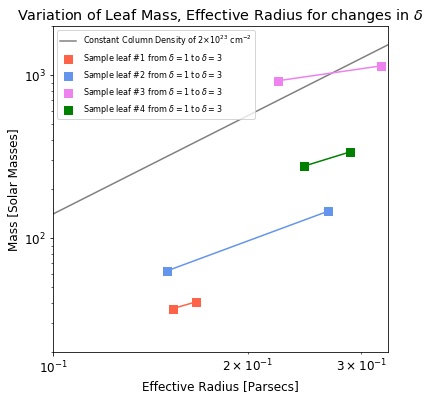

In [33]:
### make fancy plot of MR/delta variation for leaves
mass_bin = np.array([1,2e3])
print( mass_bin.shape)
radius_vals = radius_from_mass_const_col_density(mass_bin,2.*10**23)

plt.close()
plt.rcParams.update({'font.size': 12}) #set fontsize
mrfig = plt.figure(3,figsize=(6,6))
mrfig.clf()
ax = mrfig.gca()
plt.xlabel('Effective Radius [Parsecs]')
plt.ylabel('Mass [Solar Masses]')
#print mass
ax.set_title('Variation of Leaf Mass, Effective Radius for changes in $\delta$')

ax.plot(radius_vals,mass_bin,color='k',label='Constant Column Density of 2$\\times$10$^{23}$ cm$^{-2}$',alpha=0.5)


ax.scatter([r_eff_pc_d1[0],r_eff_pc_d2[0], r_eff_pc_d3[0]],[mass_d1[0],mass_d2[0], mass_d3[0]],
           s=60, color='tomato',marker='s',alpha=1.,
           label='Sample leaf #1 from $\delta = 1$ to $\delta = 3$')
ax.scatter([r_eff_pc_d1[1],r_eff_pc_d2[1], r_eff_pc_d3[1]],[mass_d1[1],mass_d2[1], mass_d3[1]],
           s=60, color='cornflowerblue',marker='s',alpha=1.,
           label='Sample leaf #2 from $\delta = 1$ to $\delta = 3$')
ax.scatter([r_eff_pc_d1[2],r_eff_pc_d2[2], r_eff_pc_d3[2]],[mass_d1[2],mass_d2[2], mass_d3[2]],
           s=60, color='violet',marker='s',alpha=1.,
           label='Sample leaf #3 from $\delta = 1$ to $\delta = 3$')
ax.scatter([r_eff_pc_d1[3],r_eff_pc_d2[3], r_eff_pc_d3[3]],[mass_d1[3],mass_d2[3], mass_d3[3]],
           s=60, color='green',marker='s',alpha=1.,
           label='Sample leaf #4 from $\delta = 1$ to $\delta = 3$')
ax.plot([r_eff_pc_d1[0],r_eff_pc_d2[0], r_eff_pc_d3[0]],[mass_d1[0],mass_d2[0], mass_d3[0]],color='tomato')
ax.plot([r_eff_pc_d1[1],r_eff_pc_d2[1], r_eff_pc_d3[1]],[mass_d1[1],mass_d2[1], mass_d3[1]],color='cornflowerblue')
ax.plot([r_eff_pc_d1[2],r_eff_pc_d2[2], r_eff_pc_d3[2]],[mass_d1[2],mass_d2[2], mass_d3[2]],color='violet')
ax.plot([r_eff_pc_d1[3],r_eff_pc_d2[3], r_eff_pc_d3[3]],[mass_d1[3],mass_d2[3], mass_d3[3]],color='green')
legend = plt.legend(loc='upper left', shadow=False, fontsize=8)
ax.set_ylim(20,2000)
ax.set_xlim(0.1,0.33)

ax.set_yscale('log')
ax.set_xscale('log')
plt.savefig(figure_path + 'dendro_change.pdf',format='pdf', dpi=100, bbox_inches='tight',overwrite=True)

plt.show()

[5.75 5.25]
10.999999998592


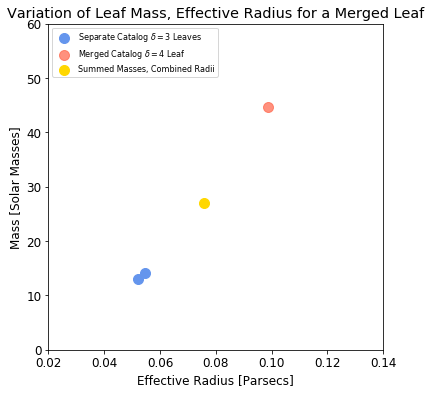

In [26]:
### now lets do that but for a merger:
###
figure_path = '/Users/hph/cmzoom_catalog/catalog_acc/parameter_study/'
directory=figure_path
catalog_d1 = Table.read(directory+'catalog_datatab_rms3e6_dv3_dd1_dp20_pp6_pm2_gal_10-21-19.fits')
catalog_d2 = Table.read(directory+'catalog_datatab_rms3e6_dv3_dd2_dp20_pp6_pm2_gal_10-21-19.fits')
catalog_d3 = Table.read(directory+'catalog_datatab_rms3e6_dv3_dd3_dp20_pp6_pm2_gal_10-21-19.fits')
separate_ids = [18688, 18544] ### grab these folks from catalog_d3
merged_ids = 17460 ### this guy lives in catalog_d4, surprising nobody

sep_cond = np.where(np.isin(catalog_d1['index'].data, separate_ids))
merged_cond = np.where(np.isin(catalog_d2['index'].data, merged_ids))

mass_sep_d1 = mass_calc_submm(Wave, dustTemp, Kappa, catalog_d1['flux_integrated'].data[sep_cond], distance)
r_eff_sep_d1 = catalog_d1['r_eff'].data[sep_cond]
r_eff_pc_sep_d1 = r_eff_sep_d1 * arcsec2pc
mass_merged_d2 = mass_calc_submm(Wave, dustTemp, Kappa, catalog_d2['flux_integrated'].data[merged_cond], distance)
r_eff_merged_d2 = catalog_d2['r_eff'].data[merged_cond]
r_eff_pc_merged_d2 = r_eff_merged_d2 * arcsec2pc

#print mass_sep_d3
#print mass_merged_d4

mass_summed = sum(mass_sep_d1)
#print mass_summed
sep_areas = catalog_d1['area_exact'].data[sep_cond]
print( sep_areas)
summed_area = sum(sep_areas)
print( summed_area)
r_eff_summed = np.power(summed_area/np.pi,0.5)
r_eff_summed_pc = r_eff_summed * arcsec2pc

plt.close()
plt.rcParams.update({'font.size': 12}) #set fontsize
mrfig = plt.figure(3,figsize=(6,6))
mrfig.clf()
ax = mrfig.gca()
plt.xlabel('Effective Radius [Parsecs]')
plt.ylabel('Mass [Solar Masses]')
#print mass
ax.set_title('Variation of Leaf Mass, Effective Radius for a Merged Leaf')
#ax.plot(radius_vals,mass_bin,color='k',label='Constant Column Density of 2.1$\\times$10$^{23}$ cm$^{-2}$',alpha=0.5)


ax.scatter([r_eff_pc_sep_d1[0],r_eff_pc_sep_d1[1]],[mass_sep_d1[0],mass_sep_d1[1]],
           s=100, color='cornflowerblue',marker='o',alpha=1.,label='Separate Catalog $\delta=3$ Leaves')
ax.scatter([r_eff_pc_merged_d2[0]],[mass_merged_d2[0]],
           s=100, color='tomato',marker='o',alpha=0.7,label='Merged Catalog $\delta = 4$ Leaf')
ax.scatter([r_eff_summed_pc],[mass_summed],
           s=100, color='gold',marker='o',alpha=1.,label='Summed Masses, Combined Radii')
ax.legend(fontsize=8,loc='upper left')
#ax.set_yscale('log')
#ax.set_xscale('log')
ax.set_ylim(0,60)
ax.set_xlim(0.02,0.14)
plt.savefig(figure_path + 'dendro_merge.pdf',format='pdf', dpi=100, bbox_inches='tight')

plt.show()

(2,)
(2,)


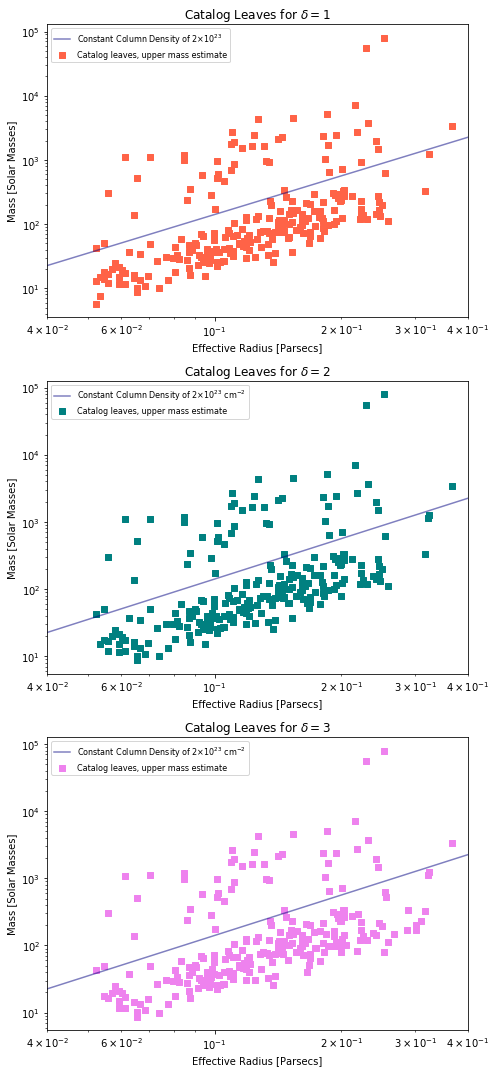

In [30]:
## plot MR for all three catalogs.
plt.close()
catalog_d1 = Table.read(directory+'catalog_datatab_rms3e6_dv3_dd1_dp20_pp6_pm2_gal_10-21-19.fits')
catalog_d2 = Table.read(directory+'catalog_datatab_rms3e6_dv3_dd2_dp20_pp6_pm2_gal_10-21-19.fits')
catalog_d3 = Table.read(directory+'catalog_datatab_rms3e6_dv3_dd3_dp20_pp6_pm2_gal_10-21-19.fits')

mass_d1 = mass_calc_submm(Wave, dustTemp, Kappa, catalog_d1['flux_integrated'].data, distance)
r_eff_d1 = catalog_d1['r_eff'].data
r_eff_pc_d1 = r_eff_d1 * arcsec2pc

mass_d2 = mass_calc_submm(Wave, dustTemp, Kappa, catalog_d2['flux_integrated'].data, distance)
r_eff_d2 = catalog_d2['r_eff'].data
r_eff_pc_d2 = r_eff_d2 * arcsec2pc

mass_d3 = mass_calc_submm(Wave, dustTemp, Kappa, catalog_d3['flux_integrated'].data, distance)
r_eff_d3 = catalog_d3['r_eff'].data
r_eff_pc_d3 = r_eff_d3 * arcsec2pc

plt.rcParams.update({'font.size': 10}) #set fontsize

#radius_vals = radius_from_mass_const_col_density(mass,2.1*10**23)
mass_bin = np.array([1e1,1e4])
print( mass_bin.shape)
radius_vals = radius_from_mass_const_col_density(mass_bin,2.*10**23)
print( radius_vals.shape)

f = plt.figure(figsize=(7,15))

#plt.xlabel('Effective Radius [Parsecs]')
#plt.ylabel('Mass [Solar Masses]')

ax1 = f.add_subplot(311)
ax1.set_title('Catalog Leaves for $\delta=1$')
ax1.scatter(r_eff_pc_d1, mass_d1,s=30, color='tomato',alpha=1.,marker='s',label='Catalog leaves, upper mass estimate')
ax1.plot(radius_vals,mass_bin,color='navy',label='Constant Column Density of 2$\\times 10^{23}$',alpha=0.5)
#ax1.errorbar(x=r_eff_pc, y=mass, yerr=noise_mass, ls='none',color='tomato')

legend = plt.legend(loc='upper left', shadow=False, fontsize=8)#'x-large')

ax1.set_xlabel('Effective Radius [Parsecs]')
ax1.set_ylabel('Mass [Solar Masses]')
ax1.set_xlim(4e-2,0.4)

ax2 = f.add_subplot(312)
ax2.set_title('Catalog Leaves for $\delta=2$')
ax2.scatter(r_eff_pc_d2,mass_d2, s=30, color='teal',alpha=1.,marker='s',label='Catalog leaves, upper mass estimate')
ax2.plot(radius_vals,mass_bin,color='navy',label='Constant Column Density of 2$\\times 10^{23}$ cm$^{-2}$',alpha=0.5)
#ax2.errorbar(x=r_eff_pc, y=mass_bgsub, yerr=noise_mass, ls='none',color='teal')
legend = plt.legend(loc='upper left', shadow=False, fontsize=8)

ax2.set_xlabel('Effective Radius [Parsecs]')
ax2.set_ylabel('Mass [Solar Masses]')
ax2.set_xlim(4e-2,0.4)

ax3 = f.add_subplot(313)
ax3.set_title('Catalog Leaves for $\delta=3$')
ax3.scatter(r_eff_pc_d3,mass_d3, s=30, color='violet',alpha=1.,marker='s',label='Catalog leaves, upper mass estimate')
ax3.plot(radius_vals,mass_bin,color='navy',label='Constant Column Density of 2$\\times 10^{23}$ cm$^{-2}$',alpha=0.5)
#ax3.errorbar(x=r_eff_pc, y=mass_bgsub, yerr=noise_mass, ls='none',color='teal')
legend = plt.legend(loc='upper left', shadow=False, fontsize=8)

ax3.set_xlabel('Effective Radius [Parsecs]')
ax3.set_ylabel('Mass [Solar Masses]')
ax3.set_xlim(4e-2,0.4)

ax1.set_xscale("log")
ax1.set_yscale("log")
ax2.set_xscale("log")
ax2.set_yscale("log")
ax3.set_xscale("log")
ax3.set_yscale("log")

#plt.gcf().subplots_adjust(bottom=0.2) #make room for x-axis


plt.tight_layout()

# Save figure
# Need to save it as a PDF, otherewise, lose transparency
plt.savefig(figure_path + 'dendro_parameter_3panel.pdf',format='pdf', dpi=100, bbox_inches='tight')
plt.show()

In [59]:
mass_bin = np.array([1e1,1e4])
print( mass_bin)
radius_vals = radius_from_mass_const_col_density(mass_bin,2.1*10**23)
print( radius_vals)

[   10. 10000.]
[0.0259933  0.82198024]
